# Regression Analysis Cultura Data

This notebook provides an overview of the statistical analysis that complements the main results in our paper. We primarily aim to test the hypothesis that the cultural production score can serve as a proxy for GDP. To evaluate this proposition, we use regression models where GDP is the dependent variable, and cultural production is one of the independent variables. We employ Bayesian Regression Modeling with Bambi—built upon PyMC—for a robust assessment of the correlation between these two variables. But before we delve into the models, we will first load and normalize the data to streamline the processing.

## Data Preparation

In [72]:
import numpy as np
import bambi as bmb
import pandas as pd
import arviz as az

# Load for Fifty year

In [150]:
granularity = 50

if granularity == 50:

    df_gdp = pd.read_csv("../gdp_analysis/results/gdp_weighted_pop_fifty.csv")
    df_gdp = df_gdp.rename(columns={"region": "region_name"})

    #df_cultura = pd.read_csv("../unseen_species_model/results/occupation/raw_results.csv", index_col = [0])
    df_cultura = pd.read_csv("../unseen_species_model/results_50/raw_results.csv", index_col = [0])

elif granularity == 10:

    df_gdp = pd.read_csv("../gdp_analysis/results/gdp_weighted_pop_decade.csv")
    df_gdp = df_gdp.rename(columns={"region": "region_name"})

    df_cultura = pd.read_csv("../unseen_species_model/results_10/raw_results.csv", index_col = [0])


df_cultura['N_est'] = df_cultura['f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
df_cultura = df_cultura.groupby(['region_name', 'decade']).agg({'N_est': 'sum', 'individual_wikidata_id':'count'}).reset_index()
df_cultura = df_cultura.rename(columns={"individual_wikidata_id": "score"})
df_cultura['survival_ratio'] = df_cultura['score']/df_cultura['N_est']

df = pd.merge(df_gdp, df_cultura, on = ['region_name', 'decade'])
df = df.rename(columns = {'decade': 'year', 'gdp_pc_weighted':'gdp_per_capita'})
df['score_cap'] = df['score']/df['pop']
df['N_est_cap'] = df['N_est']/df['pop']
    
if granularity == 10:
    df = df[df['year']>=1800]

list(set(df.region_name))
df.region_name.value_counts()

region_name
Greek World         14
United Kingdom      14
Chinese world       12
France              12
Nordic countries    12
Spain               12
Low countries       11
Italy                9
Japan                9
German world         8
Arabic world         7
Portugal             7
Indian world         6
Korea                2
Persian world        2
Name: count, dtype: int64

In [151]:
keep = ['Indian world',
 'Nordic countries',
 'Persian world',
 'Portugal',
 'United Kingdom',
 'France',
 'Greek World',
 'Arabic world',
 'Chinese world',
 'Japan',
 'German world',
 'Low countries',
 'Italy',
 'Korea',
 'Spain']

We have GDP data for the following 10 regions:

We apply a logarithmic transformation to the GDP to account for its exponential growth, as our interest lies in variables that maintain a linear correlation with GDP. We also center this at 1, which aids in straightforward interpretation. We employ the same strategy to both the production score (`score`) and the bias-corrected production score (`N_est`):

Explanation of columns:

- score: Immaterial Index (number of CPs per decade per region)
- N_est: Corrected Immaterial Index with the Unseen Species Model
- score_cap: Immaterial Index per capita (Immaterial Index/Population)
- N_est_cap: Corrected Immaterial Index per capita
- score_log: Natural Log of Immaterial Index
- score_log_std: Standardized Natural Log of Immaterial Index
- score_cap_log: Natural Log of Immaterial Index per capita
- N_est_cap_log: Natural Log of Corrected Immaterial Index per capita
- N_est_cap_log_std: Standardized Natural Log of Corrected Immaterial Index per capita
- gdp: GPD per capita
- log_gdp: Natural Log of GDP per capita
- log_gdp_std: Standardized Natural Log of GDP per capita

In [152]:
# Apply normalization

df["century"] = df["year"].round(-2)
df["score_log"] = np.log(df["score"])
df["score_cap_log"] = np.log(df["score_cap"])

df["N_est_log"] = np.log(df["N_est"])
df["N_est_cap_log"] = np.log(df["N_est_cap"])
df["score_log_std"] = df["score_log"] / df["score_log"].mean()
df["score_cap_log_std"] = np.log(df["score_cap"]) / df["score_cap_log"].mean()

df["N_est_std"] = df["N_est"] / df["N_est"].mean()
df["N_est_log_std"] = df["N_est_log"] / df["N_est_log"].mean()

df["N_est_cap_log_std"] = np.log(df["N_est_cap"]) / df["N_est_cap_log"].mean()
df["log_gdp"] = np.log(df["gdp_per_capita"])

df["log_gdp_std"] = df["log_gdp"] / df["log_gdp"].mean()
df["gdp_std"] = df["gdp_per_capita"] / df["gdp_per_capita"].mean()
df["survival_ratio_std"] = df["survival_ratio"] / df["survival_ratio"].mean()

df.sample(5)

region_name  year  gdp_per_capita           pop          N_est  score  \
37  German world  1800     1835.802091  22949.507212  196065.436004   5406   
77         Korea  1800      795.836424   6870.000000     145.952615     16   
47   Greek World  1600     1422.655812  13321.992718     300.572156     10   
71         Japan  1450      866.550000  14610.000000      72.515076     10   
76         Japan  1850     1514.815000  33384.250000    2400.297440    233   

    survival_ratio  score_cap  N_est_cap  century  ...  N_est_cap_log  \
37        0.027572   0.235561   8.543340     1800  ...       2.145152   
77        0.109625   0.002329   0.021245     1800  ...      -3.851637   
47        0.033270   0.000751   0.022562     1600  ...      -3.791484   
71        0.137902   0.000684   0.004963     1400  ...      -5.305667   
76        0.097071   0.006979   0.071899     1800  ...      -2.632492   

    score_log_std  score_cap_log_std  N_est_std  N_est_log_std  \
37       1.834910           0.326152  13.492495       1.648006   
77       0.591890           1.367590   0.010044       0.673916   
47       0.491554           1.623014   0.020684       0.771611   
71       0.491554           1.643833   0.004990       0.579320   
76       1.163683           1.120000   0.165180       1.052584   

    N_est_cap_log_std   log_gdp  log_gdp_std   gdp_std  survival_ratio_std  
37          -1.245271  7.515237     1.024291  1.111335            0.354699  
77           2.235894  6.679394     0.910369  0.481773            1.410240  
47           2.200974  7.260281     0.989541  0.861229            0.427992  
71           3.079965  6.764520     0.921972  0.524581            1.774012  
76           1.528174  7.323049     0.998096  0.917020            1.248751  

[5 rows x 23 columns]

The distribution of the logged GDP values is clearly trimodal:

## Visualy plot the relationships

In [179]:
df_cultura = pd.read_csv("../unseen_species_model/results_50/raw_results.csv", index_col = [0])
df_cultura['N_est'] = df_cultura['f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
df_cultura = df_cultura.groupby(['region_name', 'decade']).agg({'N_est': 'sum', 'individual_wikidata_id':'count'}).reset_index()
df_cultura = df_cultura.rename(columns={"individual_wikidata_id": "score"})
df_cultura['survival_ratio'] = df_cultura['score']/df_cultura['N_est']
df_cultura['score_log'] = np.log(df_cultura['score'])
df_cultura['N_est_log'] = np.log(df_cultura['N_est'])
df_cultura['log_diff_scores'] = df_cultura['N_est_log']-df_cultura['score_log']
df_cultura = df_cultura.rename(columns = {'decade': 'year'})

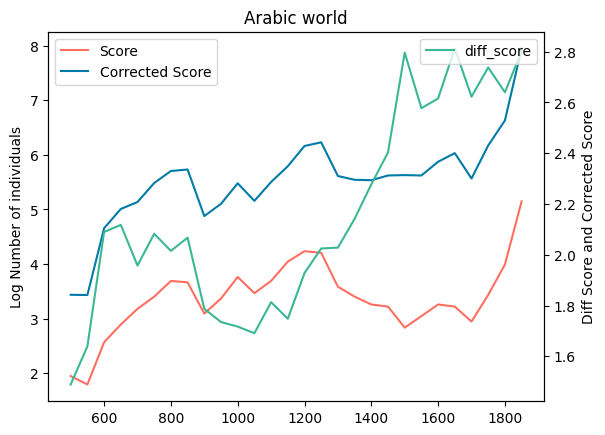

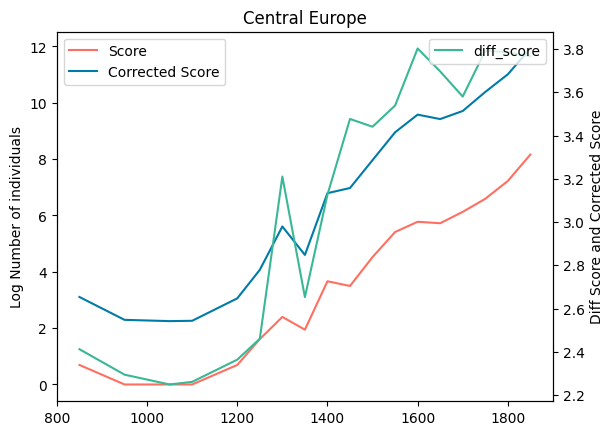

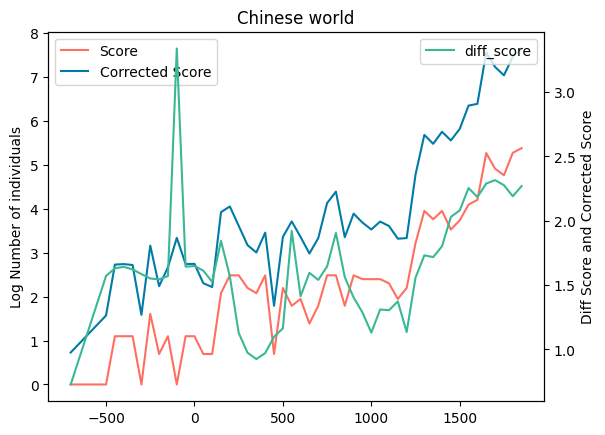

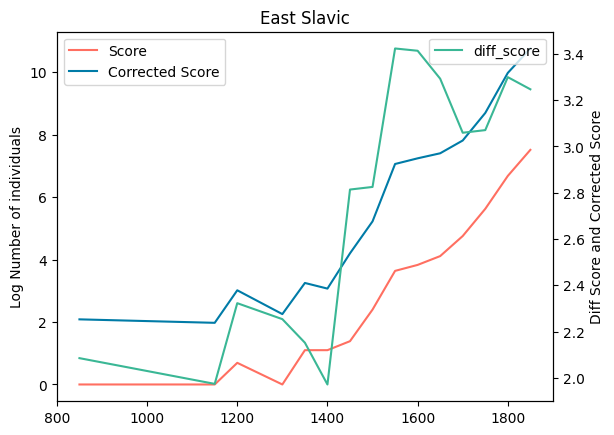

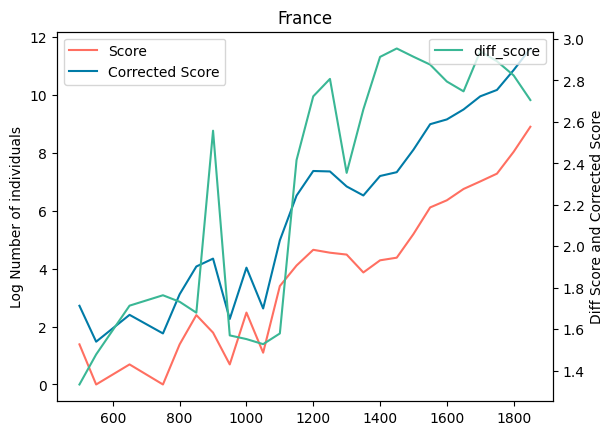

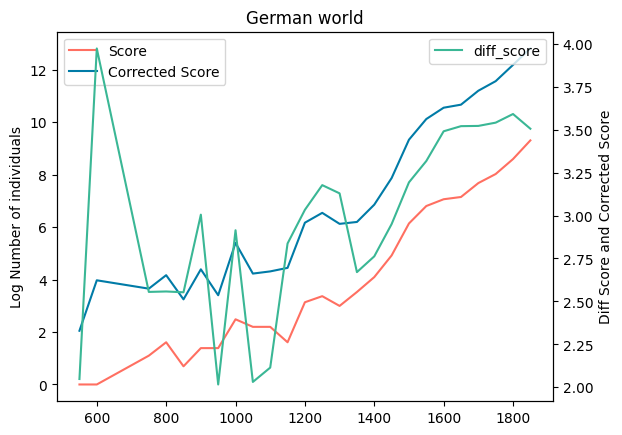

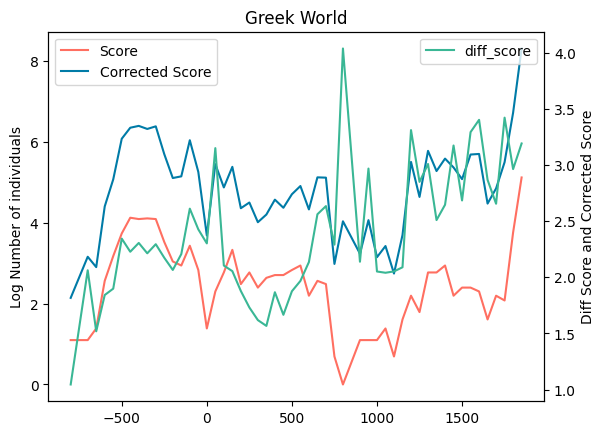

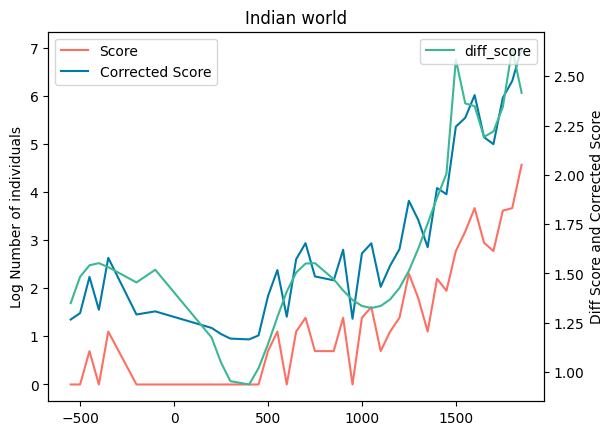

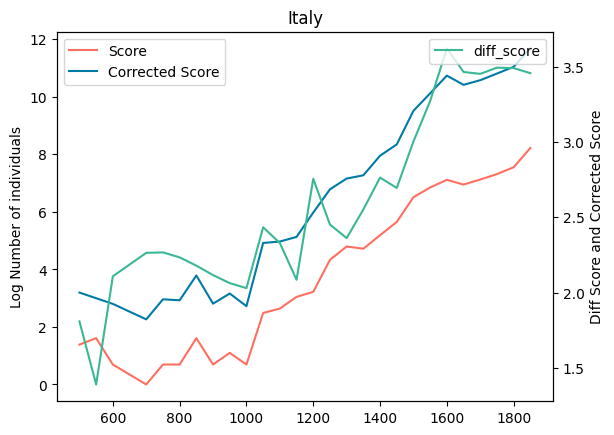

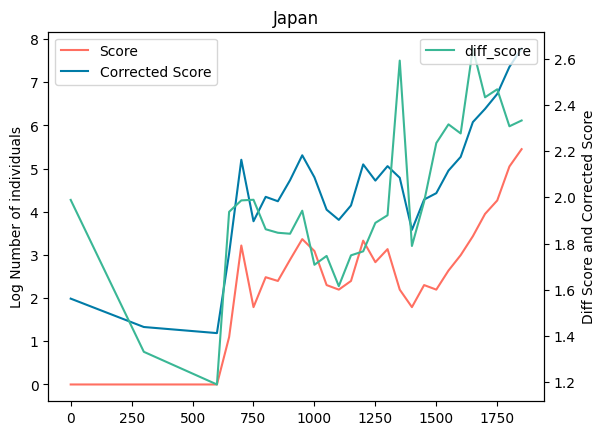

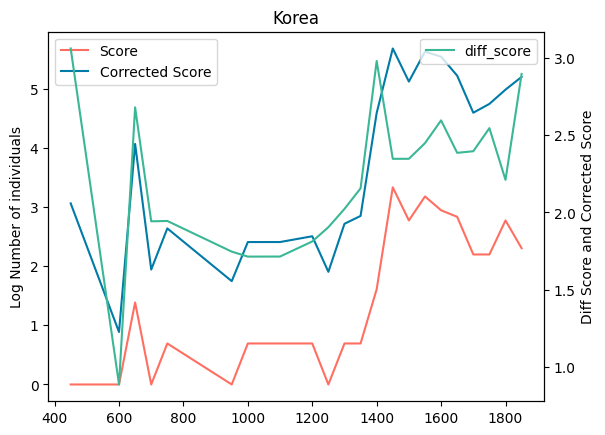

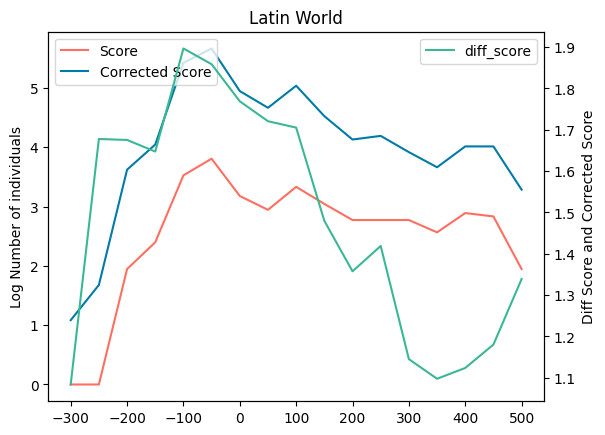

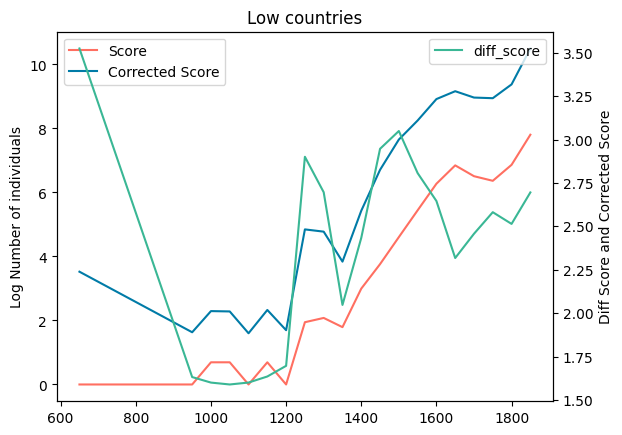

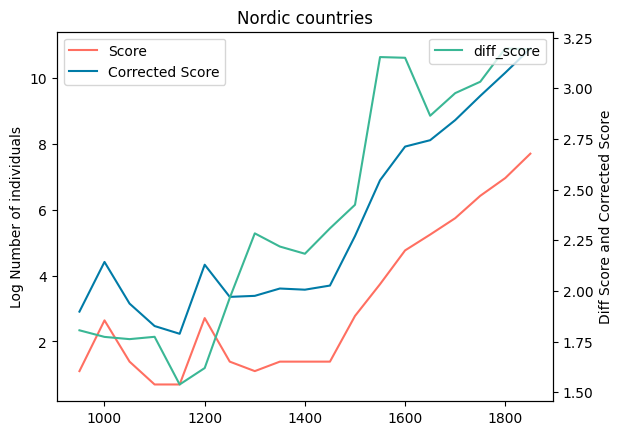

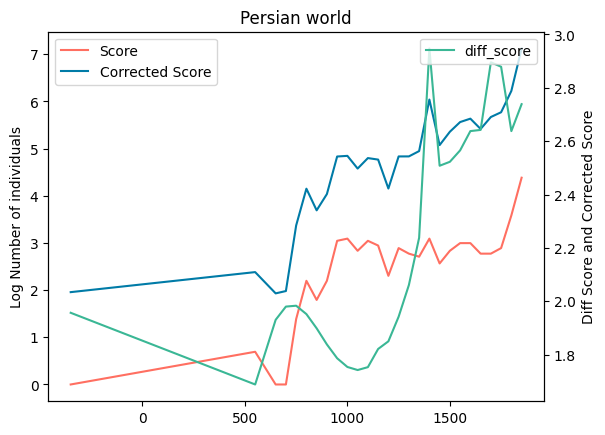

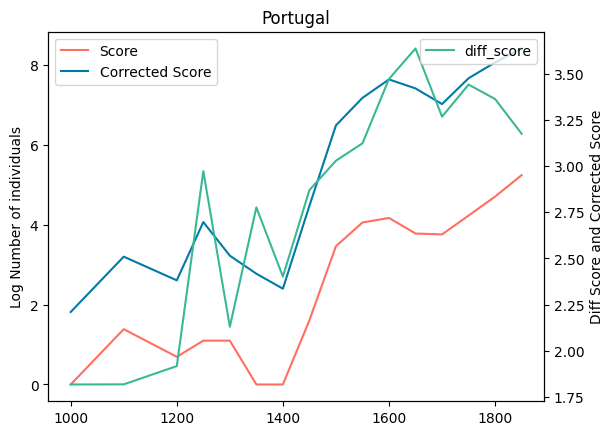

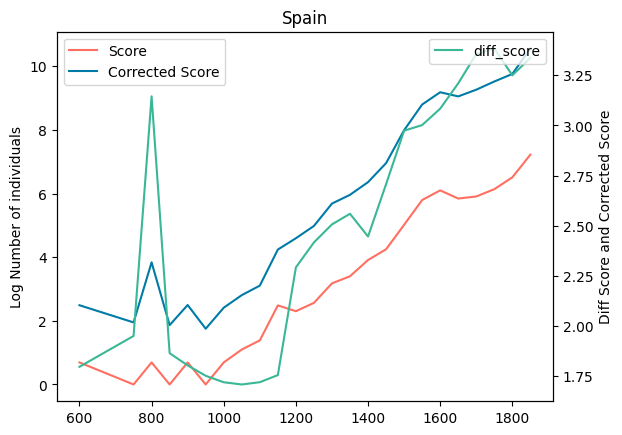

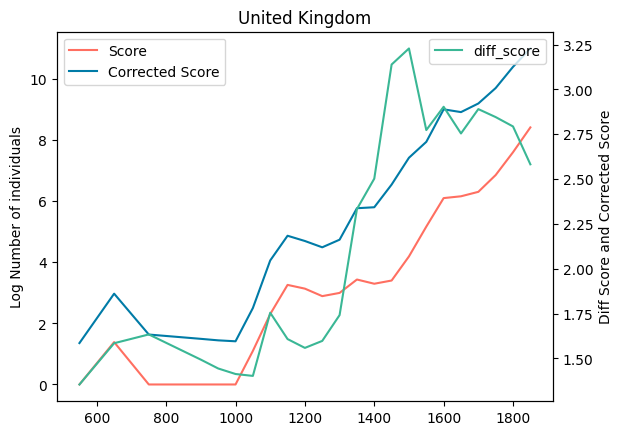

In [180]:
import matplotlib.pyplot as plt
import os

show = True

# Create the directory if it doesn't exist
directory = "index_and_corrected_index"
if not os.path.exists(directory):
    os.makedirs(directory)
    
grouped = df_cultura.groupby('region_name')

for name, group in grouped:
    fig, ax1 = plt.subplots()  # Create a figure and an axis

    # Plotting the survival ratio on the left y-axis

    ax1.plot(group['year'], group['score_log'], color='#FF6F61', label = 'Score')  # Coral Red
    ax1.plot(group['year'], group['N_est_log'], color='#007BA7', label = 'Corrected Score')  # Cerulean Blue
    ax1.set_ylabel('Log Number of individuals')  # Updated label$

    ax1.legend(loc='upper left')
   
     # Create a second y-axis for the corrected index
    ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('Diff Score and Corrected Score')  # We already handled the x-label with ax1
    ax2.plot(group['year'], group['log_diff_scores'], color='#3AB795',label='diff_score')

    ax2.legend(loc='upper right')
    plt.title(name)
    plt.savefig(os.path.join(directory, f'{name}.png'))


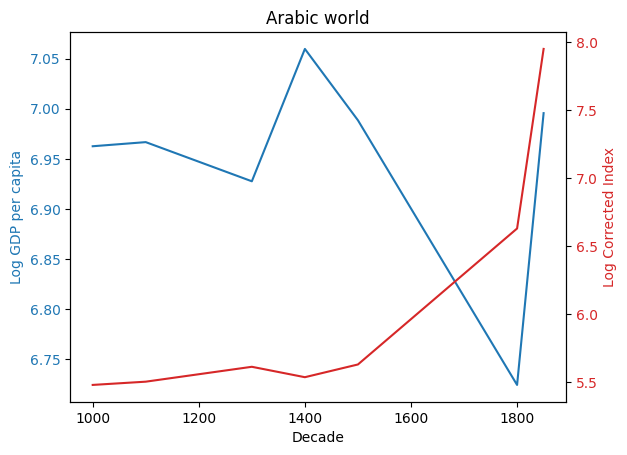

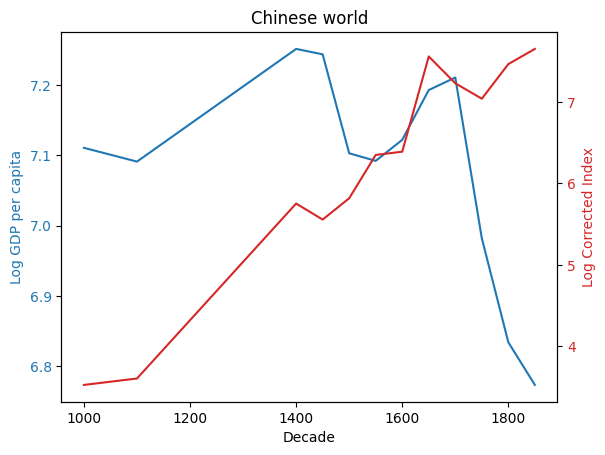

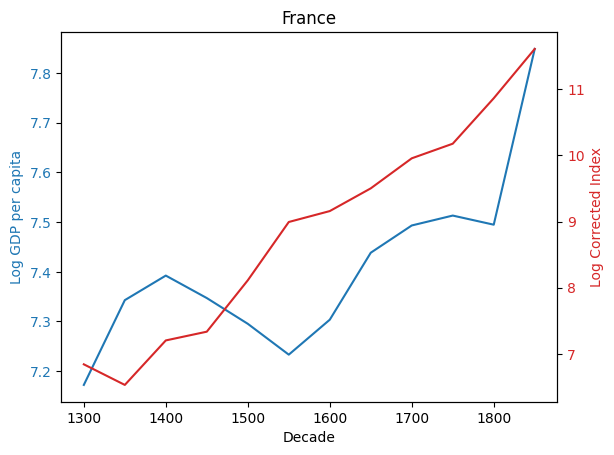

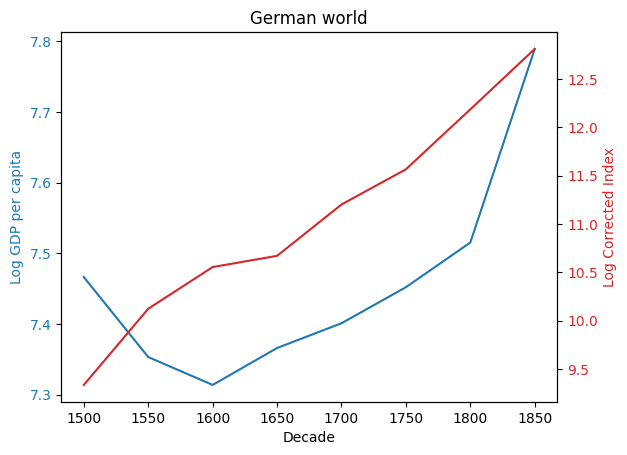

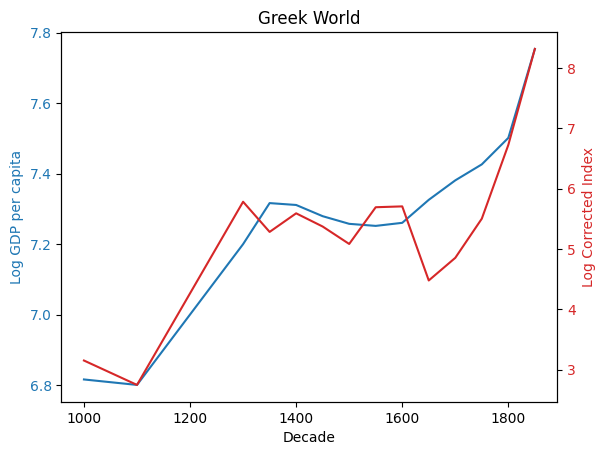

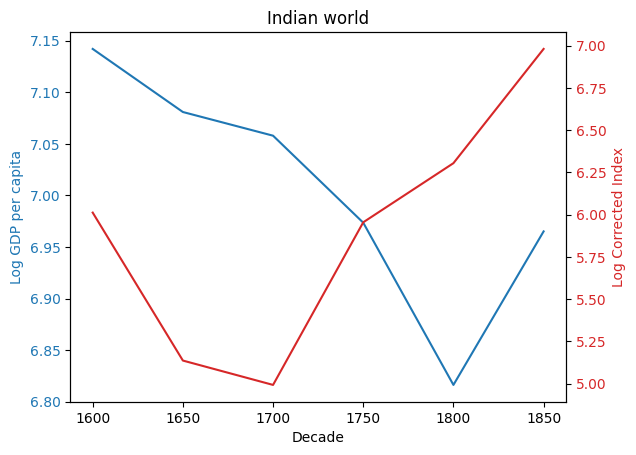

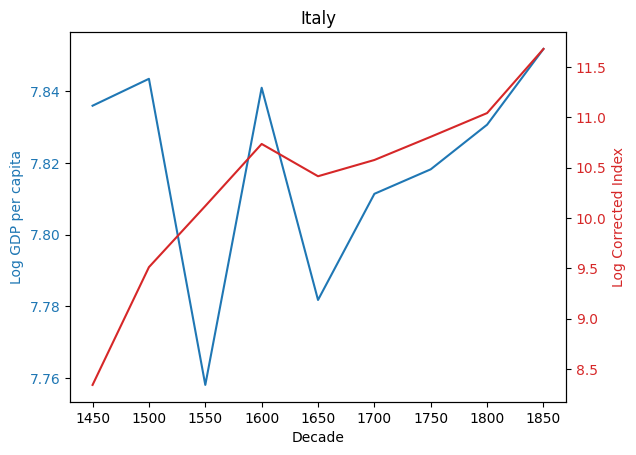

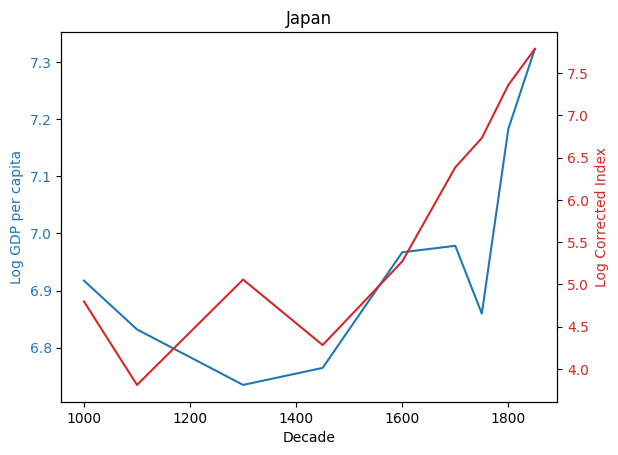

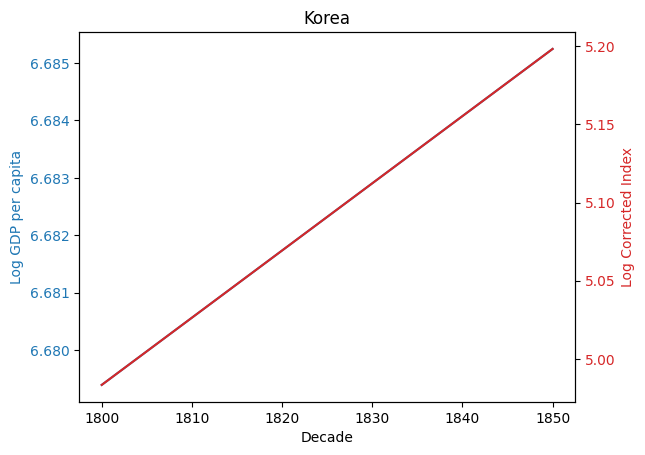

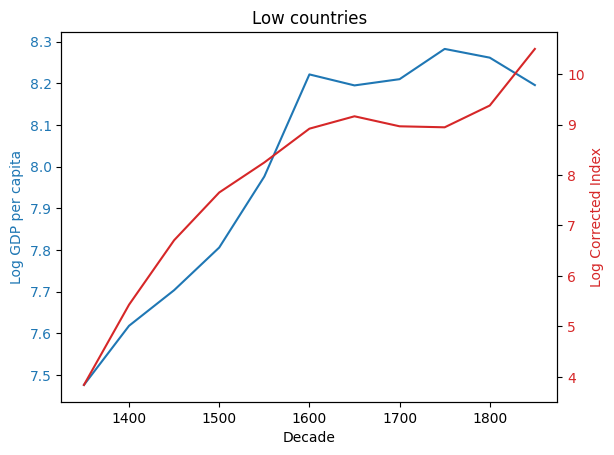

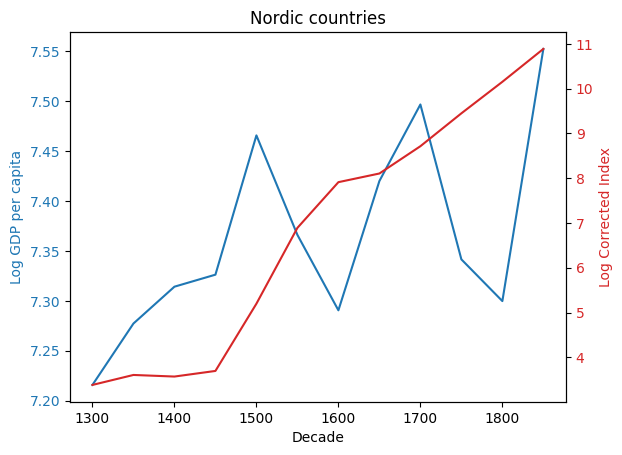

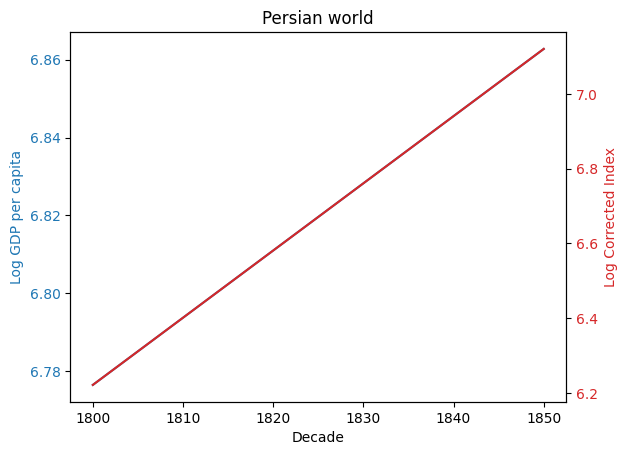

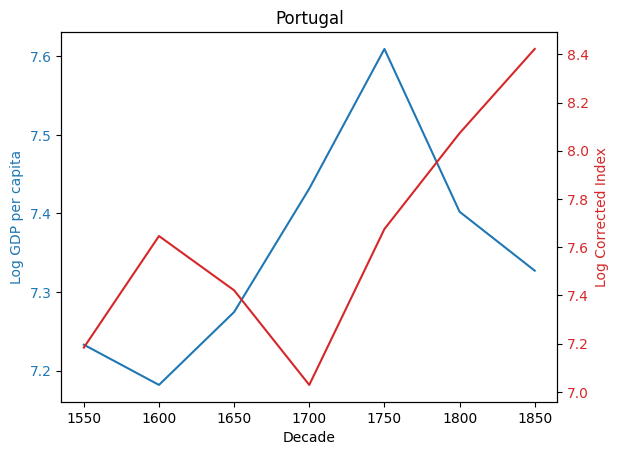

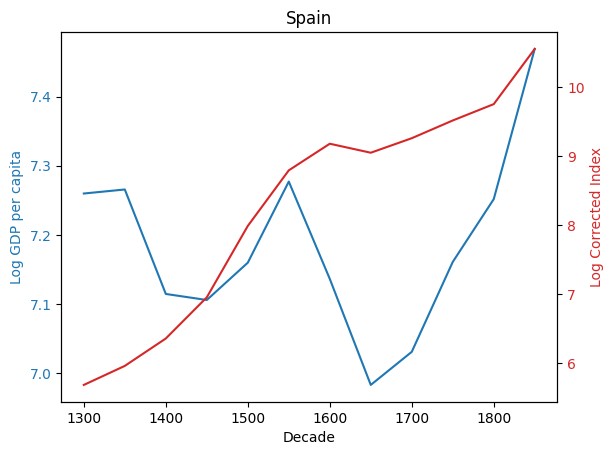

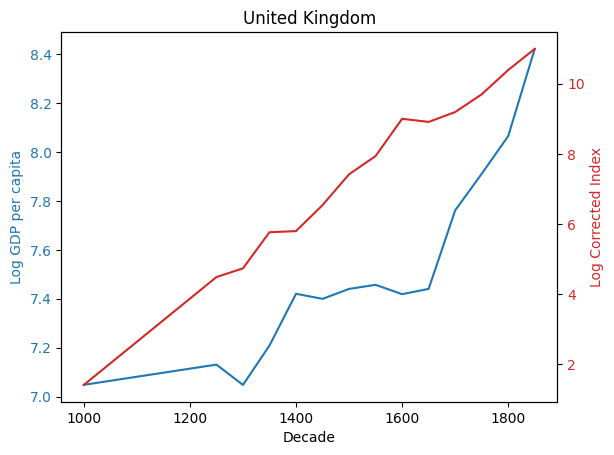

In [77]:

import matplotlib.pyplot as plt
import os

show = True

# Create the directory if it doesn't exist
directory = "gdp_corrected_index"
if not os.path.exists(directory):
    os.makedirs(directory)
    

grouped = df.groupby('region_name')

for name, group in grouped:
    fig, ax1 = plt.subplots()  # Create a figure and an axis

    # Plotting the survival ratio on the left y-axis
    color = 'tab:blue'
    ax1.set_xlabel('Decade')
    ax1.set_ylabel('Log GDP per capita', color=color)
    ax1.plot(group['year'], group['log_gdp'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a second y-axis for the corrected index
    ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Log Corrected Index', color=color)  # We already handled the x-label with ax1
    ax2.plot(group['year'], group['N_est_log'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    #ax2.set_yscale('log')

    plt.title(name)

    # Save the plot to a file
    plt.savefig(os.path.join(directory, f'{name}.png'))
    # Show plot
    if show:
        plt.show()
    plt.close(fig)  #

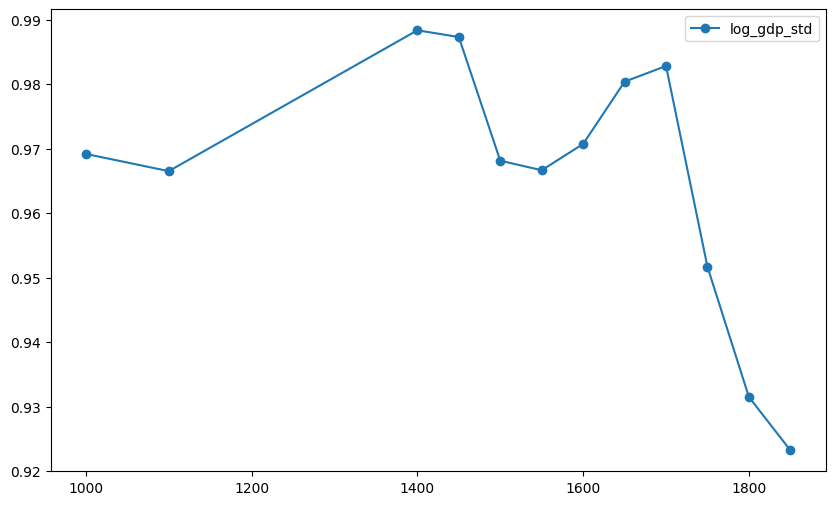

In [78]:
import matplotlib.pyplot as plt
df_filter = df[df["region_name"]=='Chinese world']

plt.figure(figsize=(10, 6))

#plt.plot(df_filter['year'], df_filter['N_est_log_std'], marker='o', label='N_est_log_std')
plt.plot(df_filter['year'], df_filter['log_gdp_std'], marker='o', label='log_gdp_std')
plt.legend()

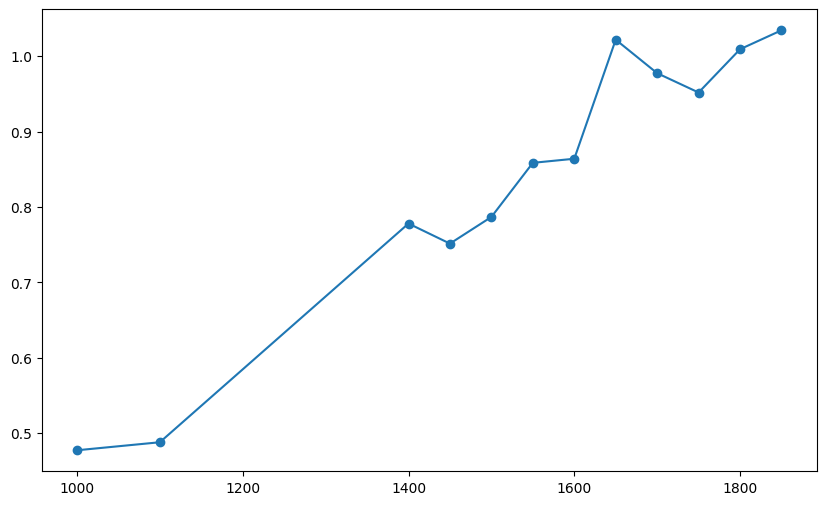

In [79]:
plt.figure(figsize=(10, 6))

plt.plot(df_filter['year'], df_filter['N_est_log_std'], marker='o', label='N_est_log_std')

### Only good model

In [139]:
models = {}

### Survival Ratio

In [81]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "survival_ratio_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_est_vs = bmb.Model(
    "log_gdp_std ~  survival_ratio_std + (survival_ratio_std|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)

m_est_vs_fit = m_est_vs.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.95,
    idata_kwargs={"log_likelihood": True})


az.summary(m_est_vs_fit)

models["log_gdp_std ~  survival_ratio_std + (survival_ratio_std|region_name)"] = m_est_vs_fit

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, survival_ratio_std, 1|region_name_sigma, 1|region_name_offset, survival_ratio_std|region_name_sigma, survival_ratio_std|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 18 seconds.


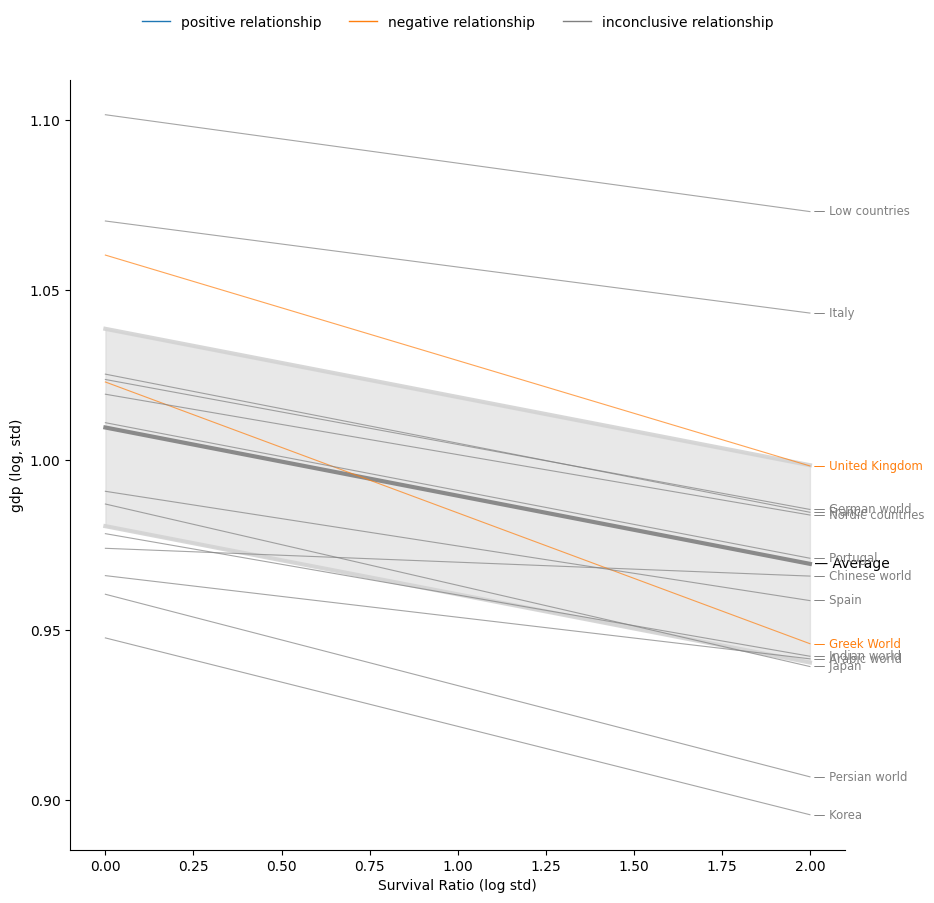

In [125]:
az.summary(m_est_vs_fit)

posterior = az.extract(m_est_vs_fit)

from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import xarray as xr

intercept_common = posterior["Intercept"]
slope_common = posterior["survival_ratio_std"]

score = np.array([0, 2])
score_xi = xr.DataArray(score)

fig, ax = plt.subplots(figsize=(10, 10))

ratio_li = az.summary(m_est_vs_fit).loc['Intercept']['hdi_3%']/az.summary(m_est_vs_fit).loc['Intercept']['mean']
ratio_ui = az.summary(m_est_vs_fit).loc['Intercept']['hdi_97%']/az.summary(m_est_vs_fit).loc['Intercept']['mean']

Y = (intercept_common + slope_common * score_xi)
Y_mean = Y.mean(axis=0)

Y_min = (intercept_common*ratio_li + slope_common * score_xi)
Y_min = Y_min.mean(axis=0)

Y_max = (intercept_common*ratio_ui + slope_common * score_xi)
Y_max = Y_max.mean(axis=0)


color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
        "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
        "grey")

ax.plot(score_xi, Y_mean, color=color, alpha=0.9, lw=3, label="Average")
ax.plot(score_xi, Y_min, color="lightgrey", alpha=0.9, lw=3, label="Average")
ax.plot(score_xi, Y_max, color="lightgrey", alpha=0.9, lw=3, label="Average")

# Plotting the confidence interval in light grey
ax.fill_between(score_xi, Y_min, Y_max, color='lightgrey', alpha=0.5)

ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + "Average",
        size="medium",
        color="black",
        ha="left",
        va="center",
    )

intercept_group_specific = posterior["1|region_name"]
slope_group_specific = posterior["survival_ratio_std|region_name"]

a = intercept_common + intercept_group_specific
b = slope_common + slope_group_specific

for region in df["region_name"].unique():

    a_region = a.sel(region_name__factor_dim=region)
    b_region = b.sel(region_name__factor_dim=region)
    
    Y = (a_region + b_region * score_xi)
    Y_mean = Y.mean(axis=0)

    color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
             "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
             "grey")
    ax.plot(score_xi, Y_mean, color=color, alpha=0.7, lw=0.8, label=region)
    ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + region,
        size="small",
        color=color,
        ha="left",
        va="center",
    )
    
ax.spines[['right', 'top']].set_visible(False)
custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]
ax.legend(custom_lines, ['positive relationship', 'negative relationship', 'inconclusive relationship'], 
           loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.1), frameon=False)
ax.set(ylabel="gdp (log, std)", xlabel="Survival Ratio (log std)");


### GDP per capita vs Corrected Index

In [140]:
models = {}

priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "N_est_log_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_est_vs = bmb.Model(
    "log_gdp_std ~  N_est_log_std + (N_est_log_std|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)

m_est_vs_fit = m_est_vs.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.95,
    idata_kwargs={"log_likelihood": True})


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, N_est_log_std, 1|region_name_sigma, 1|region_name_offset, N_est_log_std|region_name_sigma, N_est_log_std|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 38 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 346 divergences after tuning. Increase `target_accept` or reparameterize.


In [141]:
az.summary(m_est_vs_fit)

mean     sd  hdi_3%  hdi_97%  \
Intercept                                    0.796  0.024   0.750    0.839   
N_est_log_std                                0.200  0.025   0.154    0.245   
log_gdp_std_sigma                            0.016  0.001   0.014    0.019   
1|region_name_sigma                          0.046  0.016   0.020    0.078   
N_est_log_std|region_name_sigma              0.028  0.018   0.000    0.060   
1|region_name[Arabic world]                 -0.025  0.024  -0.069    0.022   
1|region_name[Chinese world]                -0.031  0.026  -0.073    0.021   
1|region_name[France]                       -0.030  0.033  -0.113    0.018   
1|region_name[German world]                 -0.044  0.032  -0.104    0.017   
1|region_name[Greek World]                   0.057  0.027   0.006    0.107   
1|region_name[Indian world]                 -0.005  0.021  -0.045    0.036   
1|region_name[Italy]                         0.002  0.028  -0.053    0.054   
1|region_name[Japan]                         0.013  0.023  -0.027    0.060   
1|region_name[Korea]                         0.035  0.023  -0.009    0.077   
1|region_name[Low countries]                 0.063  0.029  -0.002    0.112   
1|region_name[Nordic countries]             -0.038  0.031  -0.111    0.010   
1|region_name[Persian world]                -0.023  0.023  -0.067    0.021   
1|region_name[Portugal]                      0.015  0.026  -0.030    0.066   
1|region_name[Spain]                        -0.025  0.025  -0.072    0.023   
1|region_name[United Kingdom]                0.033  0.042  -0.057    0.101   
N_est_log_std|region_name[Arabic world]     -0.008  0.027  -0.065    0.039   
N_est_log_std|region_name[Chinese world]    -0.017  0.030  -0.077    0.031   
N_est_log_std|region_name[France]            0.013  0.029  -0.046    0.075   
N_est_log_std|region_name[German world]     -0.002  0.023  -0.049    0.042   
N_est_log_std|region_name[Greek World]       0.009  0.027  -0.040    0.066   
N_est_log_std|region_name[Indian world]     -0.008  0.024  -0.057    0.036   
N_est_log_std|region_name[Italy]            -0.005  0.022  -0.049    0.036   
N_est_log_std|region_name[Japan]             0.000  0.025  -0.047    0.050   
N_est_log_std|region_name[Korea]            -0.000  0.030  -0.056    0.063   
N_est_log_std|region_name[Low countries]     0.012  0.026  -0.031    0.072   
N_est_log_std|region_name[Nordic countries]  0.006  0.028  -0.051    0.066   
N_est_log_std|region_name[Persian world]    -0.008  0.027  -0.064    0.044   
N_est_log_std|region_name[Portugal]         -0.014  0.027  -0.068    0.032   
N_est_log_std|region_name[Spain]            -0.003  0.022  -0.044    0.046   
N_est_log_std|region_name[United Kingdom]    0.037  0.039  -0.023    0.110   

                                             mcse_mean  mcse_sd  ess_bulk  \
Intercept                                        0.000    0.000    3189.0   
N_est_log_std                                    0.001    0.001     902.0   
log_gdp_std_sigma                                0.000    0.000     900.0   
1|region_name_sigma                              0.001    0.001     296.0   
N_est_log_std|region_name_sigma                  0.001    0.001     370.0   
1|region_name[Arabic world]                      0.001    0.000    1261.0   
1|region_name[Chinese world]                     0.002    0.001     281.0   
1|region_name[France]                            0.003    0.003     187.0   
1|region_name[German world]                      0.001    0.000    2361.0   
1|region_name[Greek World]                       0.002    0.001     278.0   
1|region_name[Indian world]                      0.000    0.000    2513.0   
1|region_name[Italy]                             0.000    0.000    3746.0   
1|region_name[Japan]                             0.001    0.001     954.0   
1|region_name[Korea]                             0.001    0.000    1986.0   
1|region_name[Low countries]                     0.001    0.001    1207.0   
1|reg

### Visualization

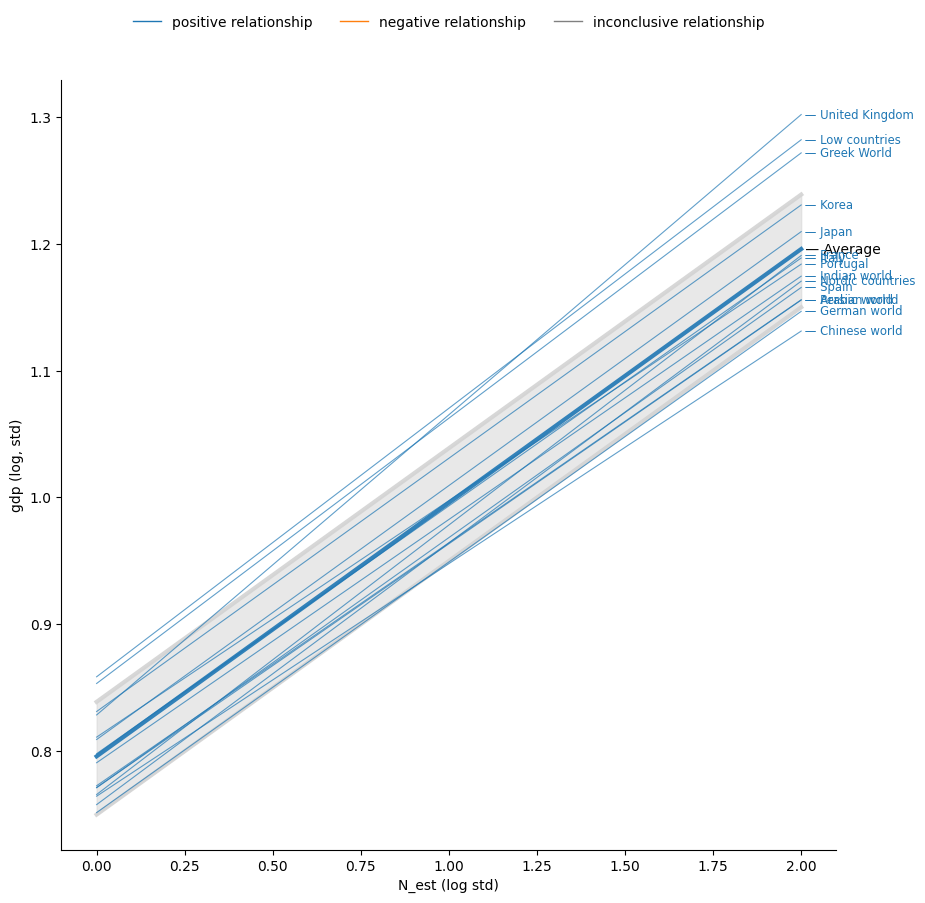

In [142]:
# NB: hitting max_treedepth is not much of a concern, at least not for model validity
# For more information about this and other warnings, see https://mc-stan.org/misc/warnings.html
# TODO, see if we can improve efficiency

posterior = az.extract(m_est_vs_fit)

from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import xarray as xr


intercept_common = posterior["Intercept"]
slope_common = posterior["N_est_log_std"]


score = np.array([0, 2])
score_xi = xr.DataArray(score)

fig, ax = plt.subplots(figsize=(10, 10))

ratio_li = az.summary(m_est_vs_fit).loc['Intercept']['hdi_3%']/az.summary(m_est_vs_fit).loc['Intercept']['mean']
ratio_ui = az.summary(m_est_vs_fit).loc['Intercept']['hdi_97%']/az.summary(m_est_vs_fit).loc['Intercept']['mean']

Y = (intercept_common + slope_common * score_xi)
Y_mean = Y.mean(axis=0)

Y_min = (intercept_common*ratio_li + slope_common * score_xi)
Y_min = Y_min.mean(axis=0)

Y_max = (intercept_common*ratio_ui + slope_common * score_xi)
Y_max = Y_max.mean(axis=0)


color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
        "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
        "grey")

ax.plot(score_xi, Y_mean, color=color, alpha=0.9, lw=3, label="Average")
ax.plot(score_xi, Y_min, color="lightgrey", alpha=0.9, lw=3, label="Average")
ax.plot(score_xi, Y_max, color="lightgrey", alpha=0.9, lw=3, label="Average")

# Plotting the confidence interval in light grey
ax.fill_between(score_xi, Y_min, Y_max, color='lightgrey', alpha=0.5)


ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + "Average",
        size="medium",
        color="black",
        ha="left",
        va="center",
    )

intercept_group_specific = posterior["1|region_name"]
slope_group_specific = posterior["N_est_log_std|region_name"]


a = intercept_common + intercept_group_specific
b = slope_common + slope_group_specific


for region in df["region_name"].unique():

    a_region = a.sel(region_name__factor_dim=region)
    b_region = b.sel(region_name__factor_dim=region)
    
    Y = (a_region + b_region * score_xi)
    Y_mean = Y.mean(axis=0)

    color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
             "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
             "grey")
    ax.plot(score_xi, Y_mean, color=color, alpha=0.7, lw=0.8, label=region)
    ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + region,
        size="small",
        color=color,
        ha="left",
        va="center",
    )
    
ax.spines[['right', 'top']].set_visible(False)
custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]
ax.legend(custom_lines, ['positive relationship', 'negative relationship', 'inconclusive relationship'], 
           loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.1), frameon=False)
ax.set(ylabel="gdp (log, std)", xlabel="N_est (log std)");


In [143]:
models["log_gdp_std ~  N_est_log_std + (N_est_log_std|region_name)"] = m_est_vs_fit

#### Only Score

In [144]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "score_log_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_est_vs = bmb.Model(
    "log_gdp_std ~  score_log_std + (score_log_std|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)

m_est_vs_fit = m_est_vs.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.95,
    idata_kwargs={"log_likelihood": True})


az.summary(m_est_vs_fit)

# NB: hitting max_treedepth is not much of a concern, at least not for model validity
# For more information about this and other warnings, see https://mc-stan.org/misc/warnings.html
# TODO, see if we can improve efficiency


posterior = az.extract(m_est_vs_fit)

models["log_gdp_std ~  score_log_std + (score_log_std|region_name)"] = m_est_vs_fit

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, score_log_std, 1|region_name_sigma, 1|region_name_offset, score_log_std|region_name_sigma, score_log_std|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 60 seconds.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.


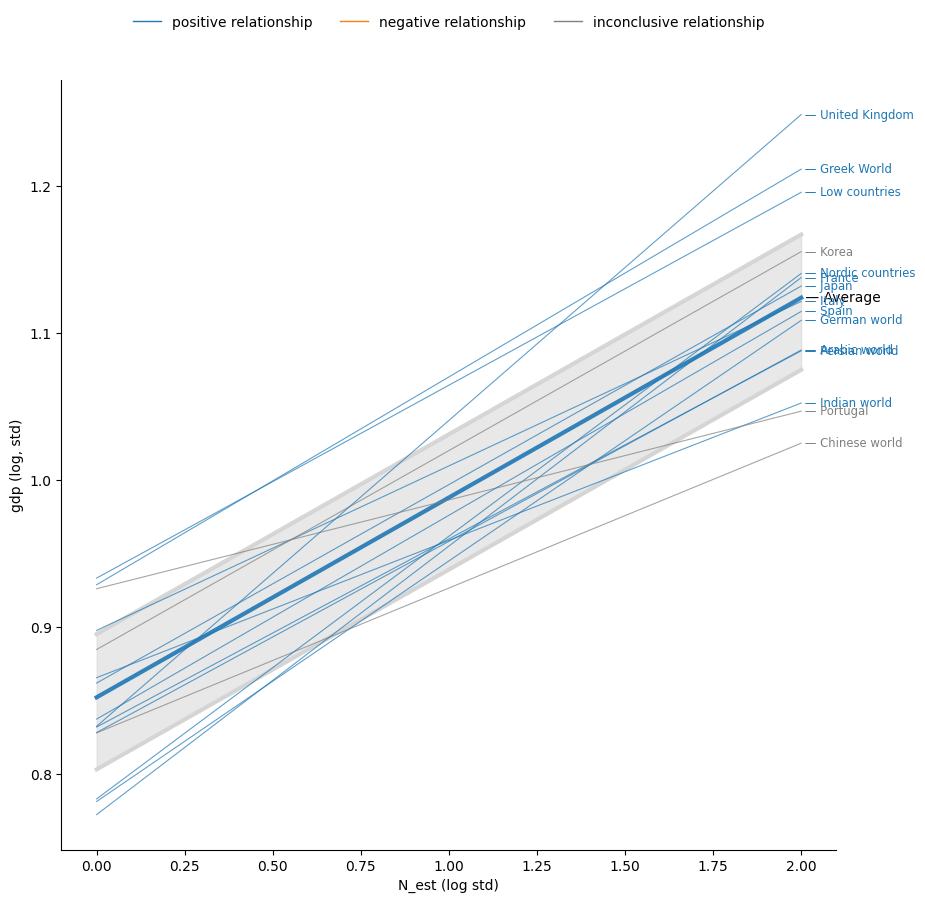

In [145]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import xarray as xr

intercept_group_specific = posterior["1|region_name"]
slope_group_specific = posterior["score_log_std|region_name"]

intercept_common = posterior["Intercept"]
slope_common = posterior["score_log_std"]

a = intercept_common + intercept_group_specific
b = slope_common + slope_group_specific

score = np.array([0, 2])
score_xi = xr.DataArray(score)

fig, ax = plt.subplots(figsize=(10, 10))


ratio_li = az.summary(m_est_vs_fit).loc['Intercept']['hdi_3%']/az.summary(m_est_vs_fit).loc['Intercept']['mean']
ratio_ui = az.summary(m_est_vs_fit).loc['Intercept']['hdi_97%']/az.summary(m_est_vs_fit).loc['Intercept']['mean']

Y = (intercept_common + slope_common * score_xi)
Y_mean = Y.mean(axis=0)

Y_min = (intercept_common*ratio_li + slope_common * score_xi)
Y_min = Y_min.mean(axis=0)

Y_max = (intercept_common*ratio_ui + slope_common * score_xi)
Y_max = Y_max.mean(axis=0)

color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
        "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
        "grey")

ax.plot(score_xi, Y_mean, color=color, alpha=0.9, lw=3, label="Average")
ax.plot(score_xi, Y_min, color="lightgrey", alpha=0.9, lw=3, label="Average")
ax.plot(score_xi, Y_max, color="lightgrey", alpha=0.9, lw=3, label="Average")

# Plotting the confidence interval in light grey
ax.fill_between(score_xi, Y_min, Y_max, color='lightgrey', alpha=0.5)
ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + "Average",
        size="medium",
        color="black",
        ha="left",
        va="center",
    )


for region in df["region_name"].unique():

    a_region = a.sel(region_name__factor_dim=region)
    b_region = b.sel(region_name__factor_dim=region)
    
    Y = (a_region + b_region * score_xi)
    Y_mean = Y.mean(axis=0)

    color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
             "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
             "grey")
    ax.plot(score_xi, Y_mean, color=color, alpha=0.7, lw=0.8, label=region)
    ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + region,
        size="small",
        color=color,
        ha="left",
        va="center",
    )
    
ax.spines[['right', 'top']].set_visible(False)
custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]
ax.legend(custom_lines, ['positive relationship', 'negative relationship', 'inconclusive relationship'], 
           loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.1), frameon=False)
ax.set(ylabel="gdp (log, std)", xlabel="N_est (log std)");


/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame 

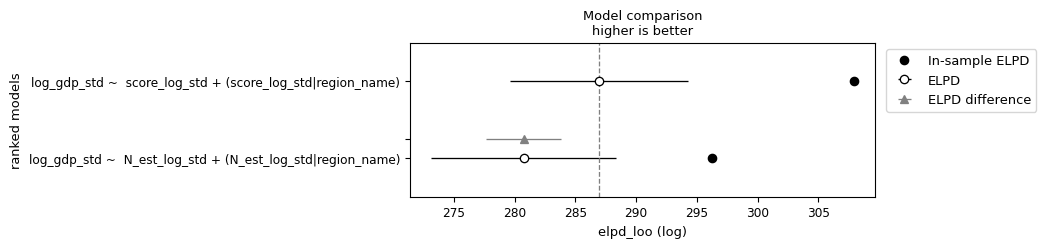

In [146]:
waic_compare = az.compare(models, ic='LOO')
az.plot_compare(waic_compare, insample_dev=True);

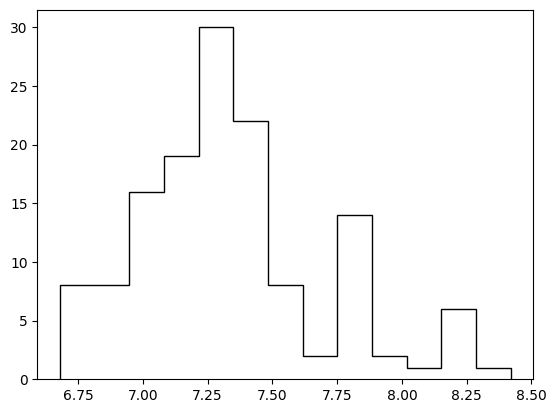

In [18]:
import matplotlib.pyplot as plt

plt.hist(df["log_gdp"].values, histtype="step", color="k", bins="fd");

We observe an intriguing trimodal structure. It was suggested by Charles that this might be due to "the fact that the Maddison data always tend to have an estimation for a region at date year=1 and then jump up to over year=1000". Filtering these instances, doesn't seem to alter the trimodal structure, however:

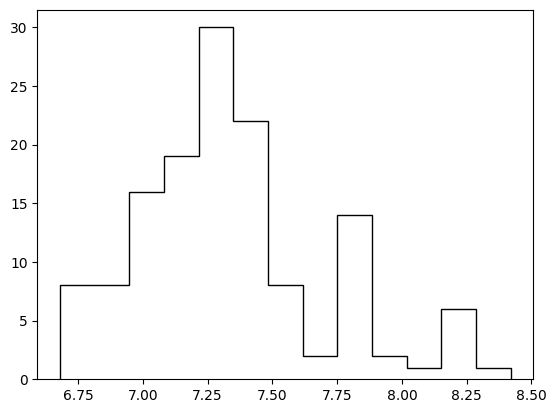

In [19]:
plt.hist(df.loc[df["year"] >= 1000, "log_gdp"].values, histtype="step", color="k", bins="fd");

The trimodality of the data is somewhat hidden when plotting against the unnormalized score and bias-corrected score. However, after log transformation, the structure becomes visible again:

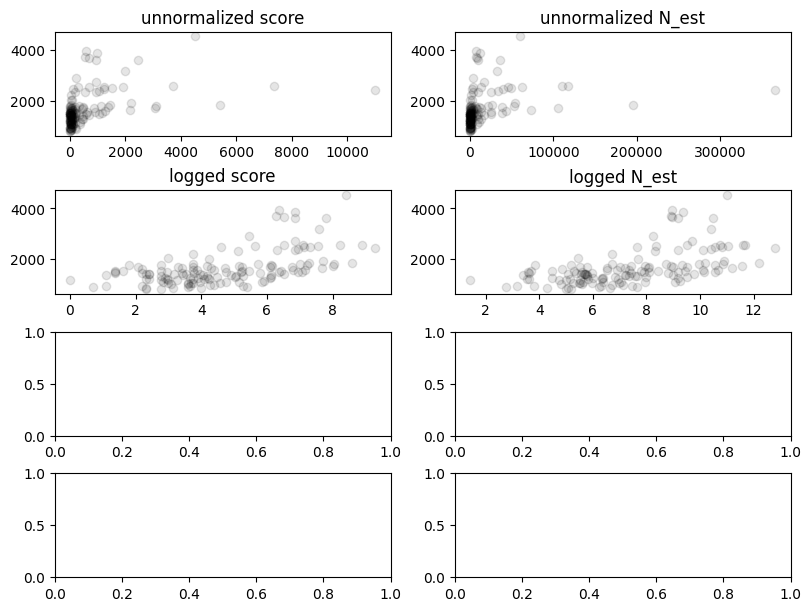

In [20]:
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(8, 6), constrained_layout=True)
axes = axes.flatten()

axes[0].scatter(df["score"], df["gdp_per_capita"], alpha=0.1, color="k")
axes[0].set_title("unnormalized score")

axes[1].scatter(df["N_est"], df["gdp_per_capita"], alpha=0.1, color="k")
axes[1].set_title("unnormalized N_est")

axes[2].scatter(df["score_log"], df["gdp_per_capita"], alpha=0.1, color="k")
axes[2].set_title("logged score")

axes[3].scatter(df["N_est_log"], df["gdp_per_capita"], alpha=0.1, color="k")
axes[3].set_title("logged N_est");

## Regression Analysis: Setting a Baseline

In our attempt to model the relationship between per capita GDP and cultural production, we utilize linear regression models. By progressively developing more intricate models, we evaluate them via approximate leave-one-out cross-validation (LOO). Initially, we establish a global relationship model that doesn't account for any regional differentiation. The model is specified as follows:

\begin{align}
\log(\text{GDP}_i) & \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i & = \alpha + \beta x_i \\
\alpha & \sim \text{Normal}(1, 1) \\
\beta & \sim \text{Normal}(0, 1) \\
\sigma & \sim \text{Exponential}(1)
\end{align} 

In this model, $\alpha$ stands for the intercept and $\beta$ denotes the coefficient of the production score.

In [21]:
models = {}

The model is easily translated to Bambi with:

In [22]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_score = bmb.Model(
    f"log_gdp_std ~ score_log_std", df, family="gaussian", priors=priors)

The model graph looks as follows:

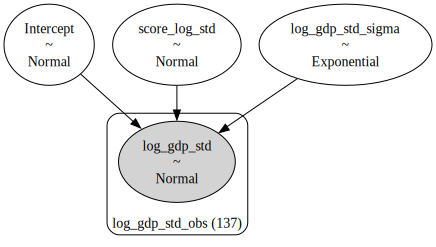

In [23]:
m_score.build()
m_score.graph()

Since this is a relatively simple model, we tune the sampler for 1000 timesteps and draw 1000 samples from the posterior:

In [24]:
fit_score = m_score.fit(draws=1000, chains=4, idata_kwargs={"log_likelihood": True})
models[f"gdp ~ score_log_std"] = fit_score

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, score_log_std]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


A quick summary of the model wth ArViz indicates that globally, the cultural production score has small yet pronounced effect:

In [25]:
az.summary(models["gdp ~ score_log_std"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept          0.931  0.009   0.914    0.949        0.0      0.0   
score_log_std      0.069  0.009   0.054    0.086        0.0      0.0   
log_gdp_std_sigma  0.041  0.002   0.036    0.046        0.0      0.0   

                   ess_bulk  ess_tail  r_hat  
Intercept            5405.0    2999.0    1.0  
score_log_std        5243.0    3129.0    1.0  
log_gdp_std_sigma    5551.0    3165.0    1.0

However, the model fit is not particularly good. To further examine this, we conduct a posterior predictive check where we plot the estimated posterior against the observed GDP distribution. Evidently, the model falls short in fitting the trimodal structure of the data:

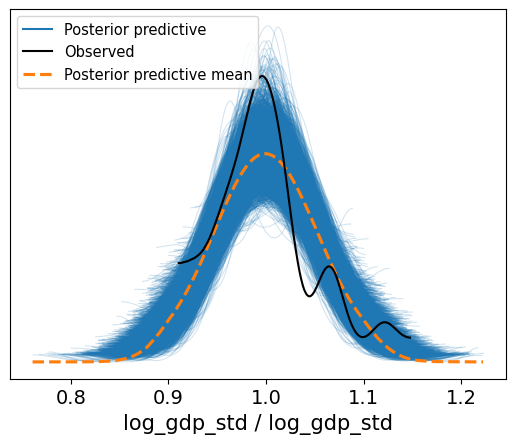

In [26]:
m_score.predict(fit_score, kind="pps")
az.plot_ppc(fit_score);

When we map the predictive posterior slopes against the empirical data in a scatter plot, it reaffirms our previous observation: the model is inadequate in accurately characterizing the data:

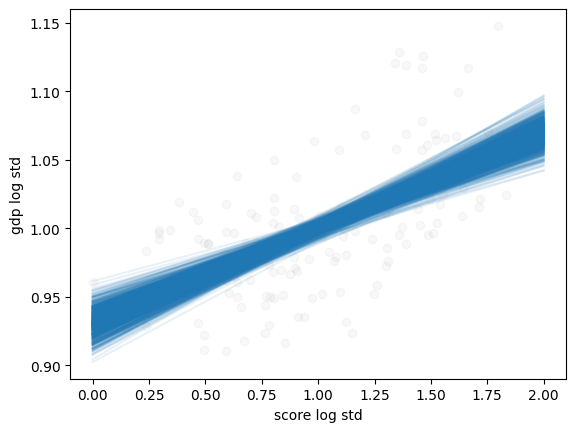

In [27]:
score_log_std_new = np.linspace(0, 2, num=200)
m_score.predict(fit_score, data=pd.DataFrame({"score_log_std": score_log_std_new}))
gdp = fit_score.posterior["log_gdp_std_mean"].sel(draw=slice(0, None, 5))

fig, ax = plt.subplots()
ax.plot(score_log_std_new, gdp.stack(samples=("chain", "draw")), color=f"C0", alpha=0.1)

ax.plot(df["score_log_std"], df["log_gdp_std"], 'o', color="grey", alpha=0.05, zorder=-5)
ax.set(xlabel="score log std", ylabel="gdp log std");

We juxtapose this model with another where we employ the bias-corrected cultural production score as opposed to the unnormalized score. While the model specification remains consistent, its implementation unfolds as follows:

In [28]:
m_est = bmb.Model(
    f"log_gdp_std ~ N_est_log_std", df, family="gaussian", priors=priors)
fit_est = m_est.fit(draws=1000, chains=4, idata_kwargs={"log_likelihood": True})
models[f"gdp ~ N_est_log_std"] = fit_est

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, N_est_log_std]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Similar to the previous analysis, a cursory analysis of the new model seems to suggest a slightly weaker but still positive correlation between the cultural production score and GDP:

In [29]:
az.summary(models["gdp ~ N_est_log_std"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept          0.906  0.012   0.884    0.929        0.0      0.0   
N_est_log_std      0.094  0.011   0.072    0.114        0.0      0.0   
log_gdp_std_sigma  0.041  0.003   0.036    0.046        0.0      0.0   

                   ess_bulk  ess_tail  r_hat  
Intercept            5512.0    2899.0    1.0  
N_est_log_std        5449.0    3112.0    1.0  
log_gdp_std_sigma    5055.0    2973.0    1.0

This relationship is visualized in the following graph:

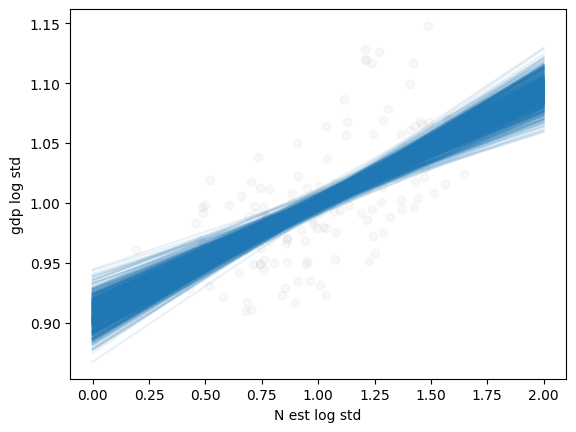

In [30]:
N_est_log_std_new = np.linspace(0, 2, num=200)
m_est.predict(fit_est, data=pd.DataFrame({"N_est_log_std": N_est_log_std_new}))
gdp = fit_est.posterior["log_gdp_std_mean"].sel(draw=slice(0, None, 5))

fig, ax = plt.subplots()
ax.plot(N_est_log_std_new, gdp.stack(samples=("chain", "draw")), color=f"C0", alpha=0.1)

ax.plot(df["N_est_log_std"], df["log_gdp_std"], 'o', color="grey", alpha=0.05, zorder=-5)
ax.set(xlabel="N est log std", ylabel="gdp log std");

However, as indicated by the posterior predictive check, the model fit continues to disappointingly underperform:

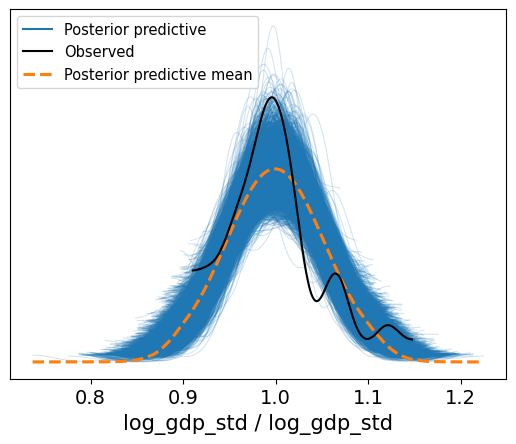

In [31]:
m_est.predict(fit_est, kind="pps")
az.plot_ppc(fit_est);

We utilize WAIC (Widely Applicable Information Criterion) or LOO to compare these models. This evaluation shows that the model incorporating the bias-corrected production variable does not perform better than one using the unnormalized variable. Nevertheless, as previously observed, both models exhibit subpar performance, suggesting caution in drawing any conclusions from this comparison. Overall, there appears evidence for a mildly positive relationship between the variables.

In [32]:
waic_compare = az.compare(models, ic='WAIC')
waic_compare

/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


rank   elpd_waic    p_waic  elpd_diff    weight  \
gdp ~ N_est_log_std     0  242.634736  2.960905    0.00000  0.707394   
gdp ~ score_log_std     1  242.087896  2.794505    0.54684  0.292606   

                           se       dse  warning scale  
gdp ~ N_est_log_std  8.501007  0.000000    False   log  
gdp ~ score_log_std  7.632745  1.664987    False   log

/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


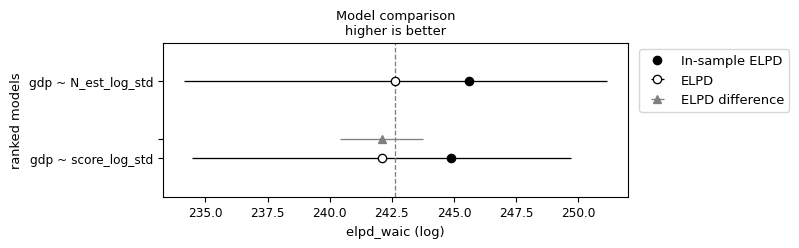

In [33]:
az.plot_compare(waic_compare, insample_dev=True);

## Hierarchical Linear Models

We now progress to a more nuanced analysis that leverages the inherent structure of our data, employing hierarchical linear models. Initially, we implement a rudimentary hierarchical model that only features varying intercepts for regions. This approach models each region as a distinct distribution, each contributing to the global intercept. The specification of the model is as follows:

\begin{align}
\log(\text{GDP}_i) & \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i & = \alpha + \alpha_{\text{region}[i]}\\
\alpha_\text{region} & \sim \text{Normal}(0, \sigma_{\text{region}}) \\
\alpha & \sim \text{Normal}(1, 1) \\
\sigma_{\text{region}} & \sim \text{HalfNormal}(1) \\
\sigma & \sim \text{Exponential}(1)
\end{align} 

In [34]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_vi = bmb.Model(
    "log_gdp_std ~ 1 + (1|region_name)", df, family="gaussian", noncentered=True, priors=priors)
m_vi

       Formula: log_gdp_std ~ 1 + (1|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 137
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            sigma ~ Exponential(lam: 1.0)

The model graph looks as follows:

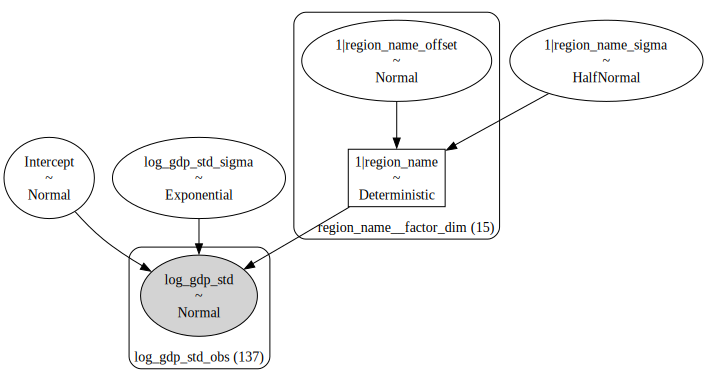

In [35]:
m_vi.build()
m_vi.graph()

The complexity of this model increases slightly, particularly due to the limited data points available for certain regions. Consequently, it's advisable to generate more posterior samples than in the previous models and proceed with a degree of caution while exploring the posterior during the sampling process:

In [36]:
m_vi_fit = m_vi.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,  # more cautious exploration of the posterior
    idata_kwargs={"log_likelihood": True}
)
models["log_gdp_std ~ (1|region_name)"] = m_vi_fit
az.summary(m_vi_fit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, 1|region_name_sigma, 1|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                        0.990  0.014   0.965    1.015        0.0   
log_gdp_std_sigma                0.029  0.002   0.025    0.032        0.0   
1|region_name_sigma              0.051  0.012   0.032    0.073        0.0   
1|region_name[Arabic world]     -0.041  0.017  -0.072   -0.010        0.0   
1|region_name[Chinese world]    -0.024  0.015  -0.052    0.006        0.0   
1|region_name[France]            0.019  0.016  -0.010    0.048        0.0   
1|region_name[German world]      0.025  0.016  -0.005    0.057        0.0   
1|region_name[Greek World]       0.002  0.015  -0.025    0.032        0.0   
1|region_name[Indian world]     -0.033  0.017  -0.065   -0.001        0.0   
1|region_name[Italy]             0.073  0.016   0.043    0.104        0.0   
1|region_name[Japan]            -0.041  0.016  -0.071   -0.011        0.0   
1|region_name[Korea]            -0.067  0.023  -0.110   -0.026        0.0   
1|region_name[Low countries]     0.097  0.016   0.067    0.127        0.0   
1|region_name[Nordic countries]  0.014  0.015  -0.015    0.044        0.0   
1|region_name[Persian world]    -0.051  0.023  -0.094   -0.010        0.0   
1|region_name[Portugal]          0.012  0.017  -0.019    0.043        0.0   
1|region_name[Spain]            -0.010  0.015  -0.040    0.018        0.0   
1|region_name[United Kingdom]    0.033  0.015   0.004    0.062        0.0   

                                 mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                            0.0    1063.0    1704.0   1.01  
log_gdp_std_sigma                    0.0    5055.0    5276.0   1.00  
1|region_name_sigma                  0.0    1340.0    2292.0   1.00  
1|region_name[Arabic world]          0.0    1658.0    2852.0   1.00  
1|region_name[Chinese world]         0.0    1392.0    2474.0   1.00  
1|region_name[France]                0.0    1370.0    2546.0   1.01  
1|region_name[German world]          0.0    1546.0    2998.0   1.00  
1|region_name[Greek World]           0.0    1338.0    2220.0   1.01  
1|region_name[Indian world]          0.0    1734.0    3189.0   1.00  
1|region_name[Italy]                 0.0    1480.0    2498.0   1.00  
1|region_name[Japan]                 0.0    1477.0    2460.0   1.00  
1|region_name[Korea]                 0.0    2917.0    4629.0   1.00  
1|region_name[Low countries]         0.0    1427.0    2369.0   1.00  
1|region_name[Nordic countries]      0.0    1293.0    2250.0   1.01  
1|region_name[Persian world]         0.0    2663.0    4244.0   1.00  
1|region_name[Portugal]              0.0    1602.0    2747.0   1.00  
1|region_name[Spain]                 0.0    1363.0    2401.0   1.01  
1|region_name[United Kingdom]        0.0    1302.0    2348.0   1.01

The sampling process appears to be effective, characterized by $\hat{r}$ scores hovering around 1 and a satisfactory effective sample size. Below, we provide a forest plot for the varying intercepts. Bear in mind that due to the construction of the model (non-centered), these intercepts should be interpreted as deviations from the global mean intercept, which is not displayed here.

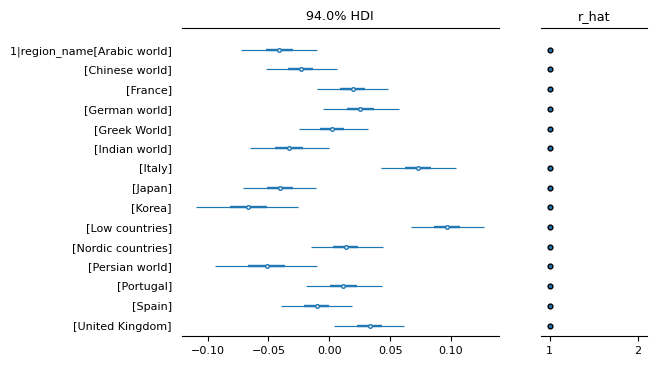

In [37]:
az.plot_forest(
    data=m_vi_fit, 
    figsize=(6, 4), 
    var_names=["1|region_name"], 
    r_hat=True, 
    combined=True, 
    textsize=8
);

Merely by incorporating the hierarchical levels associated with regions, we notice a significant improvement in the model fit, as illustrated in the subsequent posterior predictive check plot:

/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


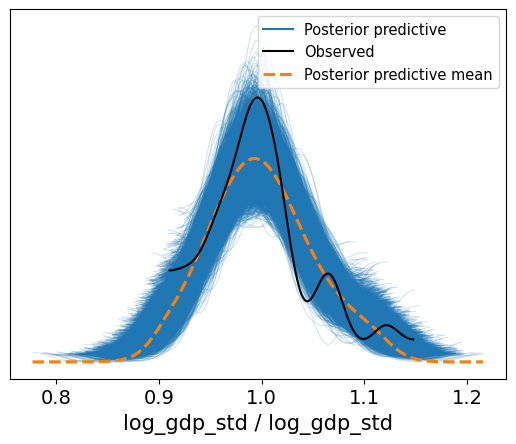

In [38]:
m_vi.predict(m_vi_fit, kind="pps")
az.plot_ppc(m_vi_fit);

### Varying Regions with Global Cultural Production Relationship

It thus seems that allowing variation in GDP per region is useful. We continue experimenting, adding the cultural production both regular and corrected to the model. The model description then becomes:

\begin{align*}
\log(\text{GDP}_i) & \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i & = \alpha + \alpha_{\text{region}[i]} \beta x_i \\
\alpha_\text{region} & \sim \text{Normal}(0, \sigma_{\text{region}}) \\
\alpha & \sim \text{Normal}(1, 1) \\
\beta & \sim \text{Normal}(0, 1) \\
\sigma_{\text{region}} & \sim \text{HalfNormal}(1) \\
\sigma & \sim \text{Exponential}(1)
\end{align*} 

Note that this is essentially the model proposed in the current version of the paper without the variable time. However, including time as a linear predictor will not change the most important lessons of the models below.

In [39]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_score_vi = bmb.Model(
    "log_gdp_std ~ score_log_std + (1|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True, 
    priors=priors
)
m_score_vi

       Formula: log_gdp_std ~ score_log_std + (1|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 137
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            score_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            sigma ~ Exponential(lam: 1.0)

The model graph looks as follows:

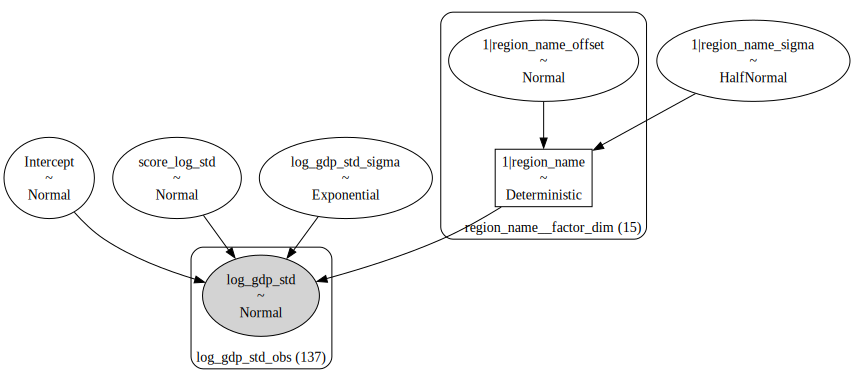

In [40]:
m_score_vi.build()
m_score_vi.graph()

In [41]:
m_score_vi_fit = m_score_vi.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,
    idata_kwargs={"log_likelihood": True}
)
models["log_gdp_std ~ score_log_std + (1|region_name)"] = m_score_vi_fit
az.summary(m_score_vi_fit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, score_log_std, 1|region_name_sigma, 1|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 8 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                        0.933  0.013   0.909    0.957        0.0   
score_log_std                    0.058  0.006   0.046    0.070        0.0   
log_gdp_std_sigma                0.022  0.001   0.020    0.025        0.0   
1|region_name_sigma              0.042  0.010   0.025    0.059        0.0   
1|region_name[Arabic world]     -0.032  0.014  -0.058   -0.007        0.0   
1|region_name[Chinese world]    -0.019  0.013  -0.042    0.005        0.0   
1|region_name[France]            0.001  0.013  -0.023    0.024        0.0   
1|region_name[German world]     -0.011  0.014  -0.036    0.015        0.0   
1|region_name[Greek World]       0.028  0.013   0.004    0.053        0.0   
1|region_name[Indian world]     -0.021  0.014  -0.046    0.007        0.0   
1|region_name[Italy]             0.044  0.013   0.018    0.068        0.0   
1|region_name[Japan]            -0.029  0.013  -0.054   -0.005        0.0   
1|region_name[Korea]            -0.046  0.018  -0.079   -0.012        0.0   
1|region_name[Low countries]     0.087  0.013   0.064    0.112        0.0   
1|region_name[Nordic countries]  0.020  0.013  -0.004    0.043        0.0   
1|region_name[Persian world]    -0.046  0.018  -0.079   -0.013        0.0   
1|region_name[Portugal]          0.015  0.014  -0.009    0.042        0.0   
1|region_name[Spain]            -0.019  0.013  -0.043    0.004        0.0   
1|region_name[United Kingdom]    0.031  0.012   0.008    0.055        0.0   

                                 mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                            0.0    1208.0    2246.0    1.0  
score_log_std                        0.0    5188.0    5114.0    1.0  
log_gdp_std_sigma                    0.0    5893.0    5239.0    1.0  
1|region_name_sigma                  0.0    1412.0    2739.0    1.0  
1|region_name[Arabic world]          0.0    1276.0    2698.0    1.0  
1|region_name[Chinese world]         0.0    1160.0    2090.0    1.0  
1|region_name[France]                0.0    1161.0    2511.0    1.0  
1|region_name[German world]          0.0    1379.0    2747.0    1.0  
1|region_name[Greek World]           0.0    1219.0    2309.0    1.0  
1|region_name[Indian world]          0.0    1526.0    2786.0    1.0  
1|region_name[Italy]                 0.0    1279.0    2873.0    1.0  
1|region_name[Japan]                 0.0    1297.0    2487.0    1.0  
1|region_name[Korea]                 0.0    2093.0    3598.0    1.0  
1|region_name[Low countries]         0.0    1265.0    2473.0    1.0  
1|region_name[Nordic countries]      0.0    1170.0    2141.0    1.0  
1|region_name[Persian world]         0.0    2284.0    4353.0    1.0  
1|region_name[Portugal]              0.0    1353.0    2724.0    1.0  
1|region_name[Spain]                 0.0    1167.0    2135.0    1.0  
1|region_name[United Kingdom]        0.0    1146.0    2333.0    1.0

Once again, the sampling appears to be successful, reflected by desirable $\hat{r}$ values and substantial effective sample sizes. The findings hint at a minimal positive global correlation between cultural production and GDP (0.035 CI [0.032, 0.037]). It seems that the model fit has experienced a slight enhancement

/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


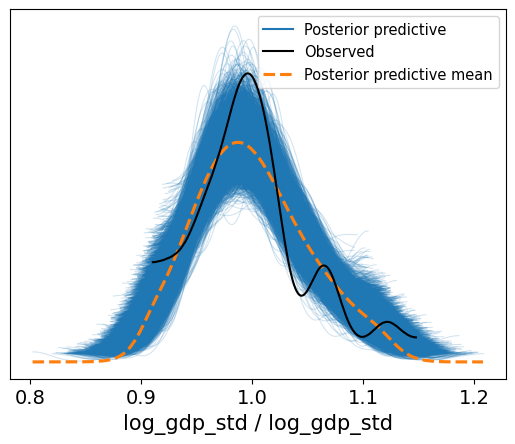

In [42]:
m_score_vi.predict(m_score_vi_fit, kind="pps")
az.plot_ppc(m_score_vi_fit);

Nevertheless, plotting the predictions against the observed data for each region provides more insightful information. This is depicted in the plot below, wherein it's evident that a global predictor of cultural production falls short in fitting the data accurately. Many regions, such as the Low Countries, the Chinese World, or Portugal, exhibit significant residuals, leaving a considerable amount of variation unexplained. Crucially, by assuming the relationship to be exclusively global, we imply it can only be unidirectional --- an assumption that, as we'll soon discover, may not necessarily hold true.

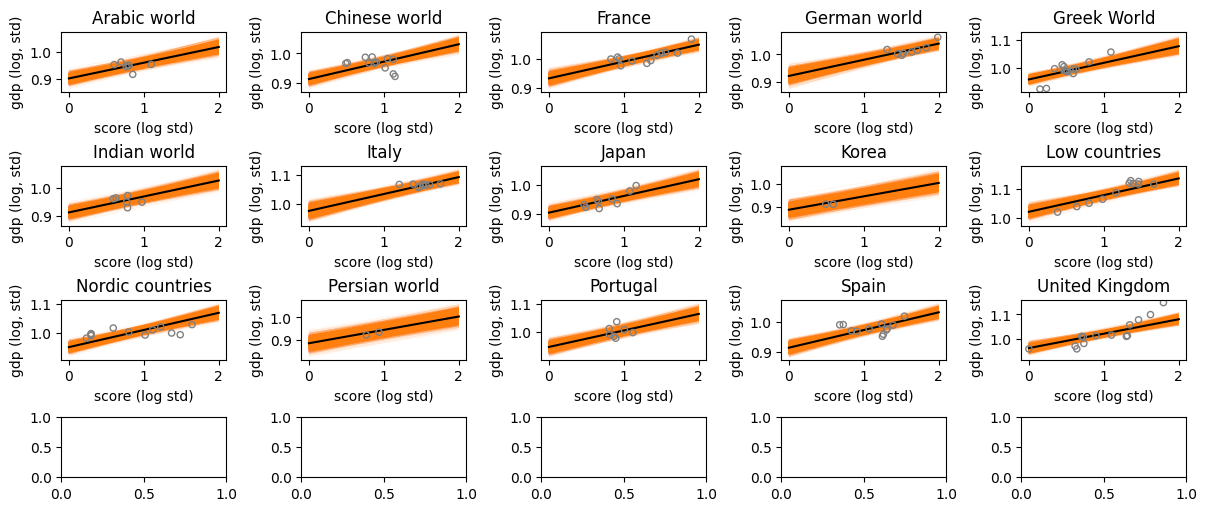

In [43]:
import xarray as xr

fig, axes = plt.subplots(ncols=5, nrows=4, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_score_vi_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["score_log_std"]
    score = np.array([0, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = slope_common

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["score_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="score (log std)", title=region_name)

Here's another visualization of the posterior predictions: the intercepts differ, but the slope (_by design_) is the same, and thus always positive:

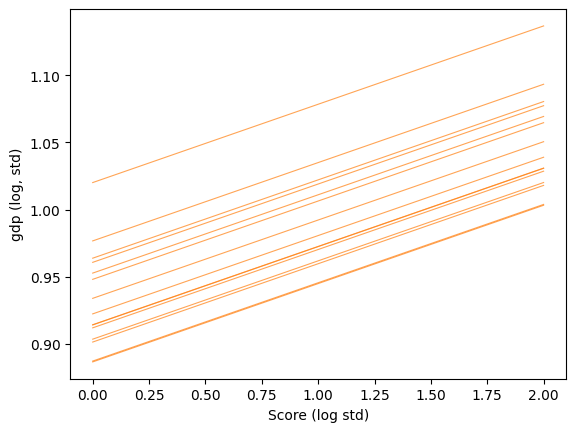

In [44]:
posterior = az.extract(m_score_vi_fit)
intercept_common = posterior["Intercept"]
slope_common = posterior["score_log_std"]
score = np.array([0, 2])

intercept_group_specific = posterior["1|region_name"]
a = intercept_common.mean() + intercept_group_specific.mean("sample")
b = slope_common.mean()
score_xi = xr.DataArray(score)
plt.plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.7, lw=0.8)
plt.ylabel("gdp (log, std)")
plt.xlabel("Score (log std)");

We perform the same analysis, swapping the cultural production score for the bias-corrected score:

In [45]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_est_vi = bmb.Model(
    "log_gdp_std ~ N_est_log_std + (1|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors)
m_est_vi

       Formula: log_gdp_std ~ N_est_log_std + (1|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 137
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            N_est_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            sigma ~ Exponential(lam: 1.0)

In [46]:
m_est_vi_fit = m_est_vi.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,
    idata_kwargs={"log_likelihood": True})

models["log_gdp_std ~ N_est_log_std + (1|region_name)"] = m_est_vi_fit
az.summary(m_est_vi_fit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, N_est_log_std, 1|region_name_sigma, 1|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                        0.915  0.015   0.888    0.942        0.0   
N_est_log_std                    0.077  0.009   0.061    0.094        0.0   
log_gdp_std_sigma                0.023  0.002   0.020    0.026        0.0   
1|region_name_sigma              0.042  0.010   0.026    0.059        0.0   
1|region_name[Arabic world]     -0.029  0.014  -0.055   -0.002        0.0   
1|region_name[Chinese world]    -0.013  0.013  -0.038    0.012        0.0   
1|region_name[France]            0.003  0.013  -0.022    0.027        0.0   
1|region_name[German world]     -0.012  0.015  -0.038    0.017        0.0   
1|region_name[Greek World]       0.022  0.013  -0.004    0.046        0.0   
1|region_name[Indian world]     -0.020  0.014  -0.047    0.007        0.0   
1|region_name[Italy]             0.042  0.014   0.016    0.070        0.0   
1|region_name[Japan]            -0.026  0.014  -0.052    0.001        0.0   
1|region_name[Korea]            -0.048  0.019  -0.083   -0.013        0.0   
1|region_name[Low countries]     0.090  0.014   0.065    0.115        0.0   
1|region_name[Nordic countries]  0.018  0.013  -0.007    0.043        0.0   
1|region_name[Persian world]    -0.046  0.019  -0.082   -0.012        0.0   
1|region_name[Portugal]          0.008  0.014  -0.019    0.033        0.0   
1|region_name[Spain]            -0.020  0.013  -0.044    0.005        0.0   
1|region_name[United Kingdom]    0.033  0.013   0.008    0.058        0.0   

                                 mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                            0.0    1289.0    2012.0   1.00  
N_est_log_std                        0.0    5486.0    4987.0   1.00  
log_gdp_std_sigma                    0.0    5183.0    5094.0   1.00  
1|region_name_sigma                  0.0    1420.0    2488.0   1.00  
1|region_name[Arabic world]          0.0    1302.0    2009.0   1.00  
1|region_name[Chinese world]         0.0    1129.0    2064.0   1.01  
1|region_name[France]                0.0    1131.0    1894.0   1.01  
1|region_name[German world]          0.0    1308.0    2417.0   1.01  
1|region_name[Greek World]           0.0    1103.0    1960.0   1.01  
1|region_name[Indian world]          0.0    1340.0    2306.0   1.01  
1|region_name[Italy]                 0.0    1236.0    2267.0   1.01  
1|region_name[Japan]                 0.0    1245.0    1905.0   1.01  
1|region_name[Korea]                 0.0    2263.0    3532.0   1.00  
1|region_name[Low countries]         0.0    1158.0    1986.0   1.01  
1|region_name[Nordic countries]      0.0    1101.0    1993.0   1.01  
1|region_name[Persian world]         0.0    1860.0    2776.0   1.00  
1|region_name[Portugal]              0.0    1279.0    2178.0   1.01  
1|region_name[Spain]                 0.0    1146.0    1846.0   1.01  
1|region_name[United Kingdom]        0.0    1073.0    1960.0   1.01

The fit appears to bear similarity to the prior model, and once more, the incorporated unidirectional relationship yields comparatively large residuals.

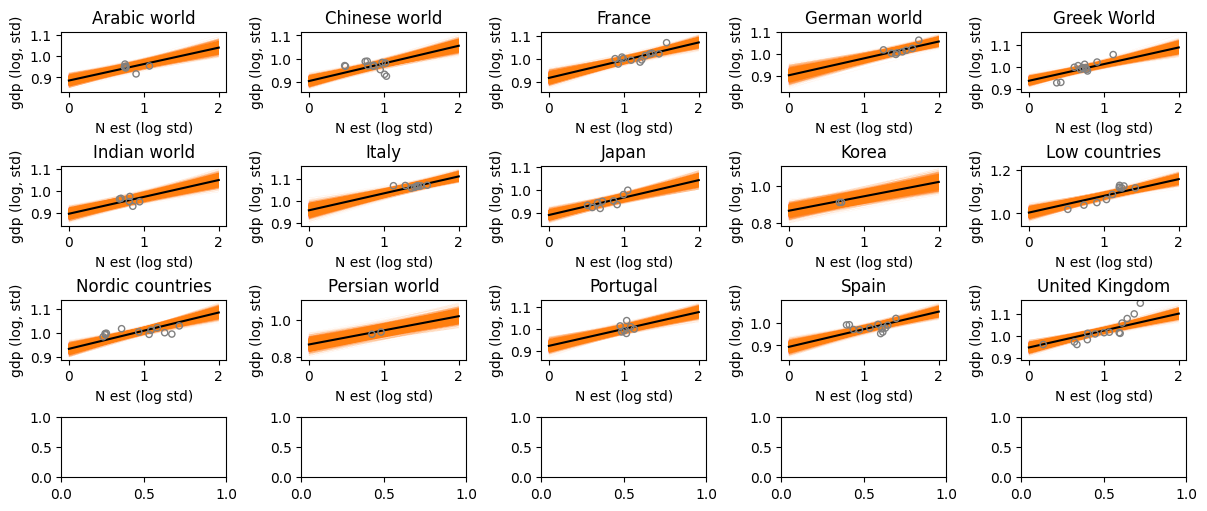

In [47]:
import xarray as xr

fig, axes = plt.subplots(ncols=5, nrows=4, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_est_vi_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["N_est_log_std"]
    score = np.array([0, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = slope_common

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["N_est_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="N est (log std)", title=region_name)

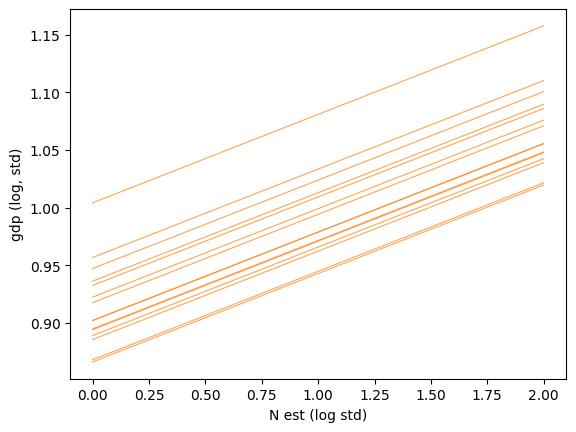

In [48]:
posterior = az.extract(m_est_vi_fit)
intercept_common = posterior["Intercept"]
slope_common = posterior["N_est_log_std"]
score = np.array([0, 2])

intercept_group_specific = posterior["1|region_name"]
a = intercept_common.mean() + intercept_group_specific.mean("sample")
b = slope_common.mean()
score_xi = xr.DataArray(score)
plt.plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.7, lw=0.8)
plt.ylabel("gdp (log, std)")
plt.xlabel("N est (log std)");

#### Model comparison

We undertake a comparison of all models explored thus far, this time employing approximate leave-one-out cross-validation (LOO). The model incorporating varying intercepts on region and using cultural score as a global predictor appears to best fit the data. As expected, it is closely followed by the model utilizing bias-corrected cultural production scores. All models featuring varying intercepts significantly outperform those with a singular global intercept. The results are demonstrated in the subsequent table and accompanying figure.

In [49]:
waic_compare = az.compare(models, ic='LOO')

/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


In [50]:
waic_compare

rank    elpd_loo      p_loo  \
log_gdp_std ~ score_log_std + (1|region_name)     0  319.386041  14.911861   
log_gdp_std ~ N_est_log_std + (1|region_name)     1  315.776061  15.121096   
log_gdp_std ~ (1|region_name)                     2  284.619303  14.189104   
gdp ~ N_est_log_std                               3  242.625836   2.969805   
gdp ~ score_log_std                               4  242.080243   2.802158   

                                               elpd_diff    weight         se  \
log_gdp_std ~ score_log_std + (1|region_name)   0.000000  0.974611  10.045041   
log_gdp_std ~ N_est_log_std + (1|region_name)   3.609980  0.000000  10.591115   
log_gdp_std ~ (1|region_name)                  34.766738  0.012518  13.706981   
gdp ~ N_est_log_std                            76.760205  0.000000   8.502787   
gdp ~ score_log_std                            77.305798  0.012872   7.634209   

                                                     dse  warning scale  
log_gdp_std ~ score_log_std + (1|region_name)   0.000000    False   log  
log_gdp_std ~ N_est_log_std + (1|region_name)   1.857041    False   log  
log_gdp_std ~ (1|region_name)                   8.604659    False   log  
gdp ~ N_est_log_std                            10.253556    False   log  
gdp ~ score_log_std                             9.874578    False   log

/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


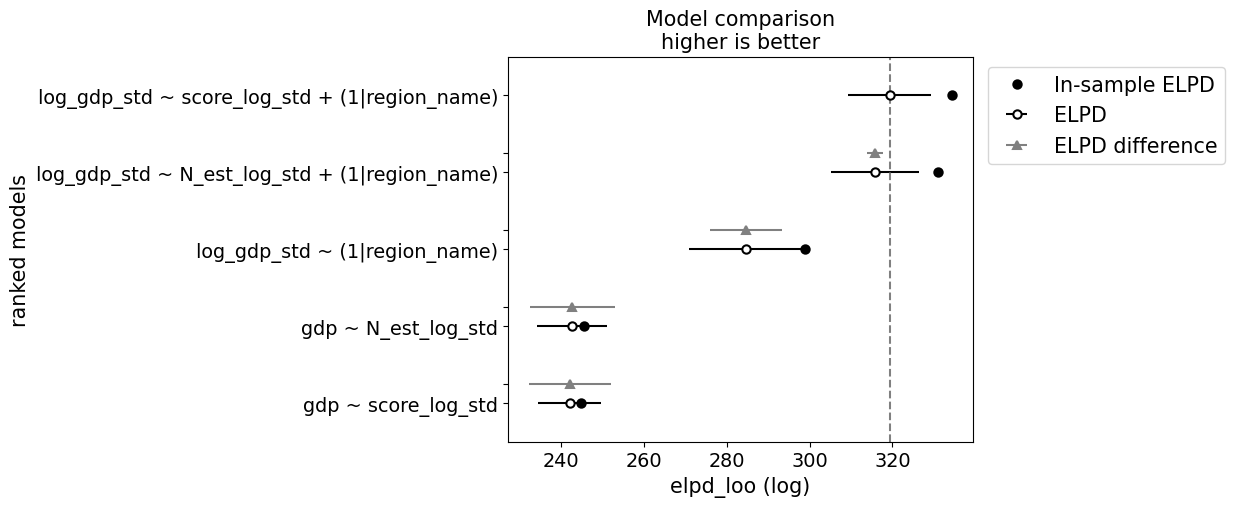

In [51]:
az.plot_compare(waic_compare, insample_dev=True);

/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/arviz/plots/compareplot.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df.sort_values(by="rank", inplace=True)
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


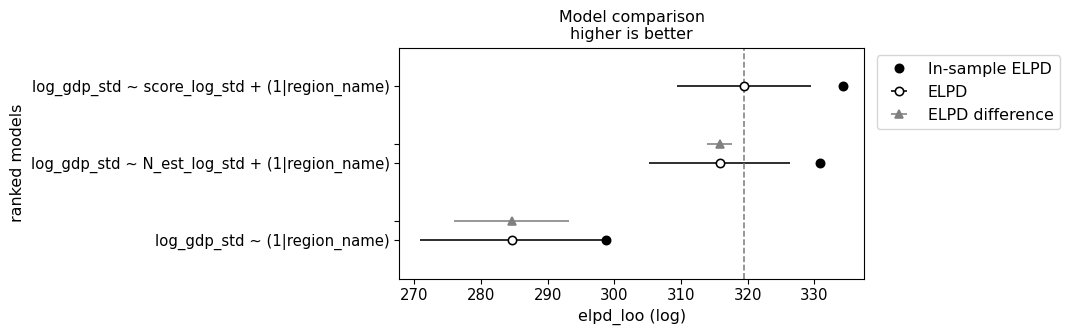

In [52]:
az.plot_compare(waic_compare.loc[waic_compare.index.str.contains("1|region_name")], insample_dev=True);

### Varying Slopes for Cultural Production in Different Regions

In our previous analysis, we presumed a global, uniform effect of cultural production on GDP per capita. However, upon observing significant discrepancies in the GDP intercepts per region, it's plausible that the relationship's slope between the cultural production score and GDP also varies. To cater to this, we construct a varying slope model with the following specification:

\begin{align*}
\log(\text{GDP}_i) & \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i & = \alpha + \alpha_{\text{region}[i]} + (\beta + \beta_{\text{region}[i]}) x_i \\
\alpha_\text{region} & \sim \text{Normal}(0, \sigma_{\alpha}) \\
\beta_\text{region} & \sim \text{Normal}(0, \sigma_{\beta}) \\
\alpha & \sim \text{Normal}(1, 1) \\
\beta & \sim \text{Normal}(0, 1) \\
\sigma_{\alpha} & \sim \text{HalfNormal}(1) \\
\sigma_{\beta} & \sim \text{HalfNormal}(1) \\
\sigma & \sim \text{Exponential}(1)
\end{align*} 

As daunting as this might seem, it can be implemented relatively straightforward, as shown below. Also note that we could further improve the model by modeling the dependence of the priors on the varying slopes and intercepts. For now we treat them as independent priors, which may not be the most efficient way to do it.

In [53]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "score_log_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_score_vs = bmb.Model(
    "log_gdp_std ~ score_log_std + (score_log_std|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)
m_score_vs

       Formula: log_gdp_std ~ score_log_std + (score_log_std|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 137
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            score_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
            score_log_std|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            sigma ~ Exponential(lam: 1.0)

The model graph looks as follows:

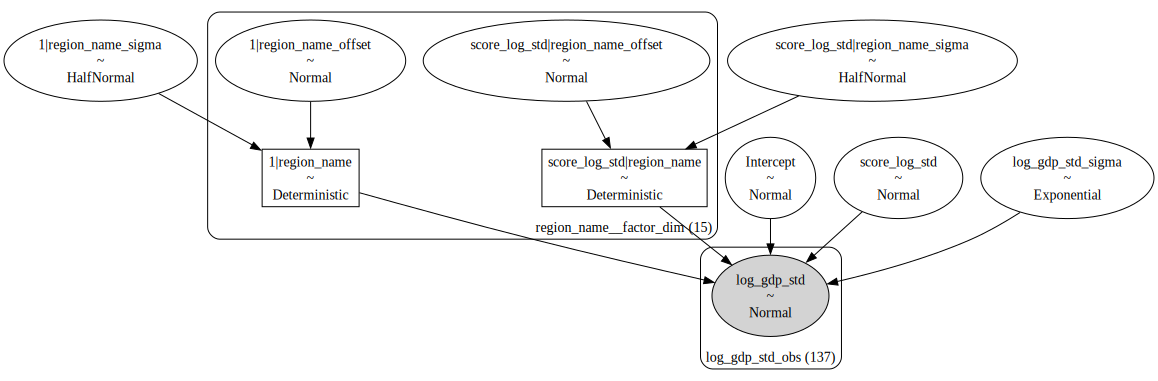

In [54]:
m_score_vs.build()
m_score_vs.graph()

Despite a considerable surge in the model's complexity, efficient sampling persists, marked by commendable $\hat{r}$ values and satisfactory effective sample sizes. The model's summary is provided below. A key observation we promptly make is the elimination of the unmistakably positive main, global effect of the cultural production score. Instead, it intersects 0 within the 97% confidence intervals, suggesting the effect is not solely positive. We'll elaborate on this further in the ensuing section.

In [55]:
m_score_vs_fit = m_score_vs.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,
    idata_kwargs={"log_likelihood": True})

models["log_gdp_std ~ score_log_std + (score_log_std|region_name)"] = m_score_vs_fit
az.summary(m_score_vs_fit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, score_log_std, 1|region_name_sigma, 1|region_name_offset, score_log_std|region_name_sigma, score_log_std|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 20 seconds.


mean     sd  hdi_3%  hdi_97%  \
Intercept                                    0.946  0.012   0.923    0.968   
score_log_std                                0.042  0.015   0.014    0.071   
log_gdp_std_sigma                            0.018  0.001   0.016    0.020   
1|region_name_sigma                          0.034  0.011   0.016    0.053   
score_log_std|region_name_sigma              0.046  0.013   0.024    0.070   
1|region_name[Arabic world]                 -0.007  0.022  -0.047    0.035   
1|region_name[Chinese world]                 0.026  0.019  -0.010    0.063   
1|region_name[France]                       -0.002  0.019  -0.039    0.033   
1|region_name[German world]                 -0.011  0.027  -0.064    0.038   
1|region_name[Greek World]                  -0.009  0.015  -0.039    0.019   
1|region_name[Indian world]                 -0.000  0.023  -0.041    0.045   
1|region_name[Italy]                         0.031  0.030  -0.022    0.088   
1|region_name[Japan]                        -0.044  0.019  -0.080   -0.007   
1|region_name[Korea]                        -0.034  0.024  -0.077    0.013   
1|region_name[Low countries]                 0.031  0.018  -0.003    0.064   
1|region_name[Nordic countries]              0.039  0.015   0.012    0.067   
1|region_name[Persian world]                -0.023  0.027  -0.076    0.025   
1|region_name[Portugal]                      0.013  0.025  -0.034    0.060   
1|region_name[Spain]                         0.011  0.019  -0.025    0.049   
1|region_name[United Kingdom]               -0.017  0.015  -0.045    0.012   
score_log_std|region_name[Arabic world]     -0.032  0.028  -0.084    0.020   
score_log_std|region_name[Chinese world]    -0.050  0.022  -0.092   -0.008   
score_log_std|region_name[France]            0.009  0.019  -0.027    0.042   
score_log_std|region_name[German world]      0.008  0.021  -0.032    0.047   
score_log_std|region_name[Greek World]       0.062  0.023   0.020    0.106   
score_log_std|region_name[Indian world]     -0.030  0.030  -0.087    0.026   
score_log_std|region_name[Italy]             0.016  0.023  -0.029    0.058   
score_log_std|region_name[Japan]             0.019  0.024  -0.028    0.063   
score_log_std|region_name[Korea]            -0.035  0.041  -0.113    0.041   
score_log_std|region_name[Low countries]     0.055  0.019   0.021    0.091   
score_log_std|region_name[Nordic countries] -0.022  0.017  -0.055    0.009   
score_log_std|region_name[Persian world]    -0.030  0.032  -0.094    0.029   
score_log_std|region_name[Portugal]          0.004  0.028  -0.050    0.056   
score_log_std|region_name[Spain]            -0.023  0.020  -0.061    0.014   
score_log_std|region_name[United Kingdom]    0.051  0.017   0.017    0.082   

                                             mcse_mean  mcse_sd  ess_bulk  \
Intercept                                          0.0      0.0    4558.0   
score_log_std                                      0.0      0.0    2583.0   
log_gdp_std_sigma                                  0.0      0.0    8001.0   
1|region_name_sigma                                0.0      0.0    3166.0   
score_log_std|region_name_sigma                    0.0      0.0    3003.0   
1|region_name[Arabic world]                        0.0      0.0    7246.0   
1|region_name[Chinese world]                       0.0      0.0    7154.0   
1|region_name[France]                              0.0      0.0    7591.0   
1|region_name[German world]                        0.0      0.0   10181.0   
1|region_name[Greek World]                         0.0      0.0    5508.0   
1|region_name[Indian world]                        0.0      0.0    7027.0   
1|region_name[Italy]                               0.0      0.0    7160.0   
1|region_name[Japan]                               0.0      0.0    5794.0   
1|region_name[Korea]                               0.0      0.0    6630.0   
1|region_name[Low countries]                       0.0      0.0    7252.0   
1|reg

Echoing our previous approach, we conduct a posterior predictive check and find that the model aligns with the data far more effectively. The difference with the simpler models is really remarkable:

/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


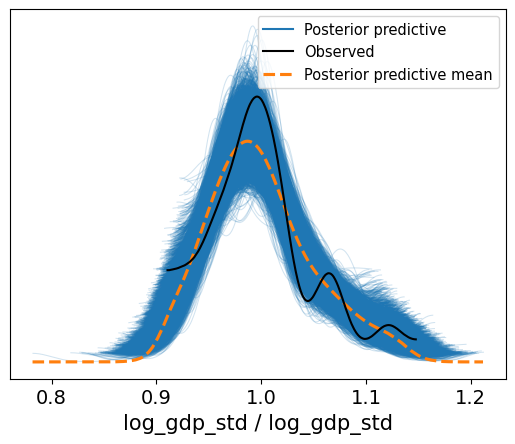

In [56]:
m_score_vs.predict(m_score_vs_fit, kind="pps")
az.plot_ppc(m_score_vs_fit);

The superior model fit becomes palpably apparent when we map the posterior predictions against the observations per region. In most instances, the varying slopes seem to align seamlessly with the data. A vital insight garnered from this plot is that the relationship between GDP and cultural production isn't universally positive across all regions. A pronounced positive correlation between the two variables is noticeable for the Low Countries, the United Kingdom, Japan, and to a slightly lesser degree, Spain. Conversely, the relationship appears inverted for the Chinese World, Eastern Europe, Italy, and the Arabic World. Portugal, France, and Central Europe do not appear to exhibit a distinct relationship, neither positive nor negative.

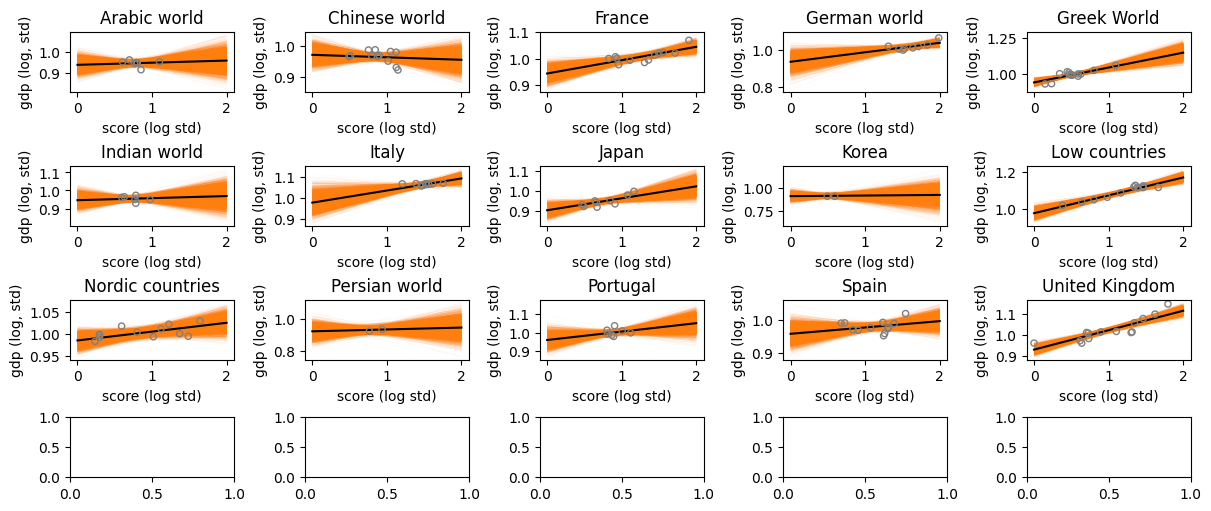

In [57]:
fig, axes = plt.subplots(ncols=5, nrows=4, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_score_vs_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["score_log_std"]
    score = np.array([0, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    slope_specific_0 = posterior["score_log_std|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = (slope_common + slope_specific_0)

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["score_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="score (log std)", title=region_name)

The ensuing plot illustrates the mean posterior distribution for each region, facilitating a more discernible understanding of regions that showcase a positive correlation between GDP and cultural production, and those that bear a negative or ambiguous relationship. The plot vividly indicates that some regions maintain a positive association, while others harbor a negative one. Thus, this analysis affirms that the incorporation of varying slopes in our model was justified and introduces valuable nuance to our exploration. **It underlines that we cannot unequivocally assert a positive correlation between cultural production and GDP, as this relationship varies by region.**

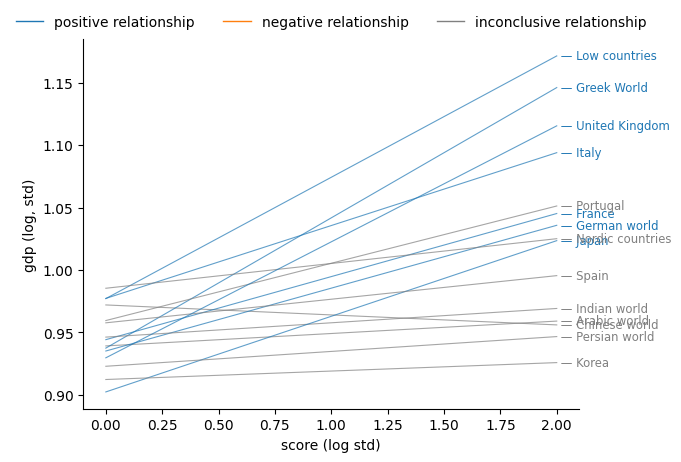

In [58]:
from matplotlib.lines import Line2D

intercept_group_specific = posterior["1|region_name"]
slope_group_specific = posterior["score_log_std|region_name"]

a = intercept_common + intercept_group_specific
b = slope_common + slope_group_specific

score_xi = xr.DataArray(score)

fig, ax = plt.subplots()
for region in df["region_name"].unique():

    a_region = a.sel(region_name__factor_dim=region)
    b_region = b.sel(region_name__factor_dim=region)
    
    Y = (a_region + b_region * score_xi)
    Y_mean = Y.mean(axis=0)

    color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
             "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
             "grey")
    ax.plot(score_xi, Y_mean, color=color, alpha=0.7, lw=0.8, label=region)
    ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + region,
        size="small",
        color=color,
        ha="left",
        va="center",
    )
    
ax.spines[['right', 'top']].set_visible(False)
custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]
ax.legend(custom_lines, ['positive relationship', 'negative relationship', 'inconclusive relationship'], 
           loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.1), frameon=False)
ax.set(ylabel="gdp (log, std)", xlabel="score (log std)");

#### Covarying slopes and intercepts

To further scrutinize the region-specific slope attributes, we illustrate the covariance between region-specific intercepts and slopes. The hypothesis is the potential correlation between the intercepts and slopes, which may indicate, for instance, an enhanced or diminished GDP increase or decrease corresponding to higher or lower intercepts. The ensuing plot depicts this relationship. Although most regions don't seem to manifest a distinctly pronounced relationship between intercepts and slopes, there are a handful of intriguing cases where interaction is noticeable. For instance, in the German world, the Greek world, and in the Latin world, a negative correlation is observed, implying a decrease in slope as the intercept escalates. Contrarily, regions like the Low Countries, although having an average intercept (hence its position around zero), boast an above-average slope. On the other hand, the Chinese world, despite having an average intercept, showcases a below-average slope.

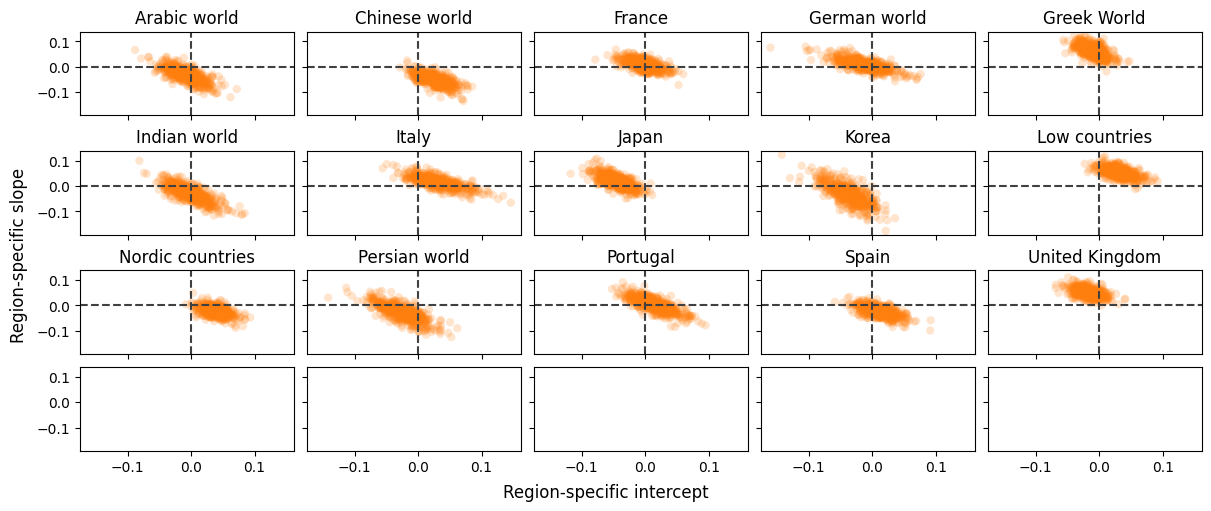

In [59]:
import matplotlib

regions = df["region_name"].unique()

fig, axes = plt.subplots(ncols=5, nrows=4, figsize=(12, 5), sharex=True, sharey=True, constrained_layout=True)

# #  extract a subsample from the posterior and stack the chain and draw dims
posterior = az.extract(m_score_vs_fit, num_samples=500)
for i, (region, ax) in enumerate(zip(regions, axes.flatten())):
    post = posterior.sel(region_name__factor_dim=region)
    X = post["1|region_name"].data
    Y = post["score_log_std|region_name"].data
    ax.scatter(
        X, Y,
        facecolor="C1", edgecolor="none", alpha=0.2)
    ax.set(title=region)

    ax.axhline(c="0.25", ls="--")
    ax.axvline(c="0.25", ls="--")
    
fig.supylabel('Region-specific slope')
fig.supxlabel('Region-specific intercept');
plt.savefig("covariance-plot.pdf")

Below, I repeat the analysis, again swapping cultural production for the bias-corrected score.

# Good Model

In [60]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "N_est_log_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_est_vs = bmb.Model(
    "log_gdp_std ~  N_est_log_std + (N_est_log_std|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)
m_est_vs

       Formula: log_gdp_std ~  N_est_log_std + (N_est_log_std|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 137
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            N_est_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
            N_est_log_std|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            sigma ~ Exponential(lam: 1.0)

In [61]:
m_est_vs_fit = m_est_vs.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.95,
    idata_kwargs={"log_likelihood": True})

models["log_gdp_std ~ N_est_log_std + (N_est_log_std|region_name)"] = m_est_vs_fit

az.summary(m_est_vs_fit)

# NB: hitting max_treedepth is not much of a concern, at least not for model validity
# For more information about this and other warnings, see https://mc-stan.org/misc/warnings.html
# TODO, see if we can improve efficiency

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, N_est_log_std, 1|region_name_sigma, 1|region_name_offset, N_est_log_std|region_name_sigma, N_est_log_std|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 31 seconds.


mean     sd  hdi_3%  hdi_97%  \
Intercept                                    0.929  0.014   0.902    0.956   
N_est_log_std                                0.059  0.018   0.026    0.093   
log_gdp_std_sigma                            0.018  0.001   0.016    0.021   
1|region_name_sigma                          0.039  0.013   0.017    0.062   
N_est_log_std|region_name_sigma              0.054  0.015   0.030    0.083   
1|region_name[Arabic world]                 -0.000  0.026  -0.053    0.048   
1|region_name[Chinese world]                 0.035  0.023  -0.005    0.080   
1|region_name[France]                       -0.008  0.024  -0.052    0.037   
1|region_name[German world]                 -0.011  0.032  -0.068    0.051   
1|region_name[Greek World]                  -0.029  0.021  -0.070    0.009   
1|region_name[Indian world]                  0.005  0.027  -0.045    0.060   
1|region_name[Italy]                         0.035  0.034  -0.024    0.101   
1|region_name[Japan]                        -0.039  0.023  -0.085    0.003   
1|region_name[Korea]                        -0.029  0.030  -0.087    0.026   
1|region_name[Low countries]                 0.015  0.023  -0.027    0.058   
1|region_name[Nordic countries]              0.046  0.018   0.013    0.082   
1|region_name[Persian world]                -0.022  0.032  -0.085    0.037   
1|region_name[Portugal]                      0.007  0.032  -0.056    0.065   
1|region_name[Spain]                         0.018  0.024  -0.025    0.065   
1|region_name[United Kingdom]               -0.024  0.018  -0.059    0.010   
N_est_log_std|region_name[Arabic world]     -0.037  0.033  -0.097    0.025   
N_est_log_std|region_name[Chinese world]    -0.059  0.027  -0.113   -0.009   
N_est_log_std|region_name[France]            0.014  0.023  -0.030    0.057   
N_est_log_std|region_name[German world]      0.007  0.025  -0.040    0.053   
N_est_log_std|region_name[Greek World]       0.070  0.028   0.018    0.124   
N_est_log_std|region_name[Indian world]     -0.034  0.035  -0.098    0.033   
N_est_log_std|region_name[Italy]             0.012  0.028  -0.040    0.065   
N_est_log_std|region_name[Japan]             0.017  0.029  -0.036    0.074   
N_est_log_std|region_name[Korea]            -0.039  0.043  -0.119    0.045   
N_est_log_std|region_name[Low countries]     0.075  0.024   0.031    0.122   
N_est_log_std|region_name[Nordic countries] -0.029  0.021  -0.070    0.009   
N_est_log_std|region_name[Persian world]    -0.032  0.037  -0.103    0.036   
N_est_log_std|region_name[Portugal]          0.004  0.032  -0.060    0.063   
N_est_log_std|region_name[Spain]            -0.031  0.024  -0.077    0.014   
N_est_log_std|region_name[United Kingdom]    0.061  0.021   0.023    0.100   

                                             mcse_mean  mcse_sd  ess_bulk  \
Intercept                                          0.0      0.0    6890.0   
N_est_log_std                                      0.0      0.0    4144.0   
log_gdp_std_sigma                                  0.0      0.0    4963.0   
1|region_name_sigma                                0.0      0.0    2741.0   
N_est_log_std|region_name_sigma                    0.0      0.0    3085.0   
1|region_name[Arabic world]                        0.0      0.0   10226.0   
1|region_name[Chinese world]                       0.0      0.0    7065.0   
1|region_name[France]                              0.0      0.0   10100.0   
1|region_name[German world]                        0.0      0.0   10226.0   
1|region_name[Greek World]                         0.0      0.0    6394.0   
1|region_name[Indian world]                        0.0      0.0    9727.0   
1|region_name[Italy]                               0.0      0.0    7050.0   
1|region_name[Japan]                               0.0      0.0    7298.0   
1|region_name[Korea]                               0.0      0.0    8637.0   
1|region_name[Low countries]                       0.0      0.0   10146.0   
1|reg

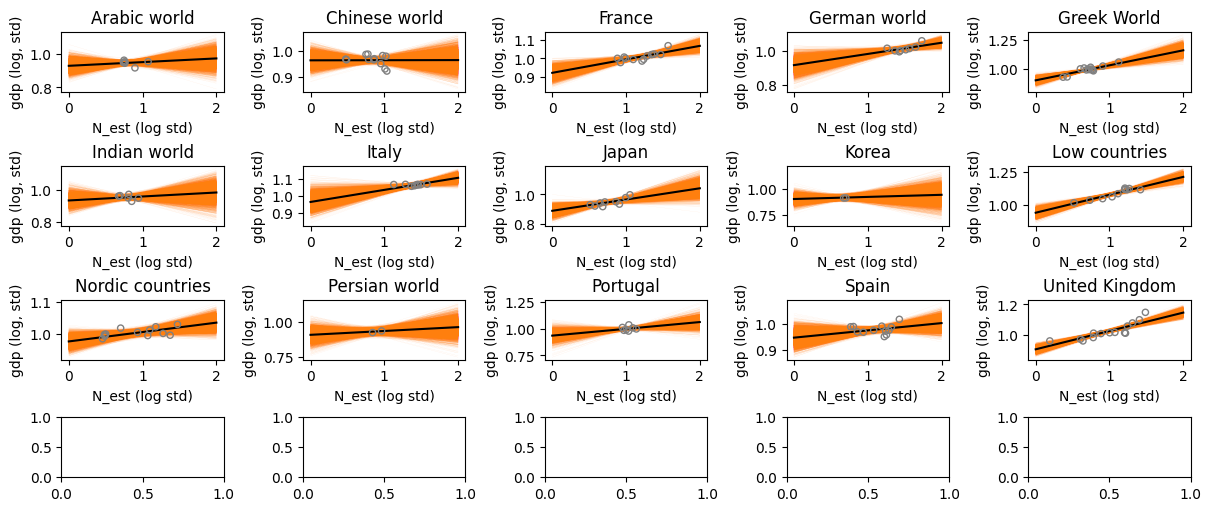

In [62]:
fig, axes = plt.subplots(ncols=5, nrows=4, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_est_vs_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["N_est_log_std"]
    score = np.array([0, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    slope_specific_0 = posterior["N_est_log_std|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = (slope_common + slope_specific_0)

    score_xi = xr.DataArray(score)
    
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)

    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")

    axes[i].scatter(data_0["N_est_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    
    axes[i].set(ylabel="gdp (log, std)", xlabel="N_est (log std)", title=region_name)

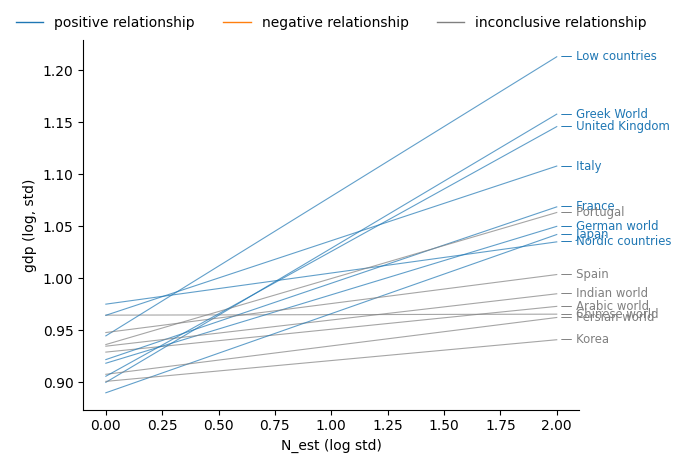

In [63]:
from matplotlib.lines import Line2D

intercept_group_specific = posterior["1|region_name"]
slope_group_specific = posterior["N_est_log_std|region_name"]

intercept_common = posterior["Intercept"]
slope_common = posterior["N_est_log_std"]

a = intercept_common + intercept_group_specific
b = slope_common + slope_group_specific

score = np.array([0, 2])
score_xi = xr.DataArray(score)

fig, ax = plt.subplots()
for region in df["region_name"].unique():

    a_region = a.sel(region_name__factor_dim=region)
    b_region = b.sel(region_name__factor_dim=region)
    
    Y = (a_region + b_region * score_xi)
    Y_mean = Y.mean(axis=0)

    color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
             "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
             "grey")
    ax.plot(score_xi, Y_mean, color=color, alpha=0.7, lw=0.8, label=region)
    ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + region,
        size="small",
        color=color,
        ha="left",
        va="center",
    )
    
ax.spines[['right', 'top']].set_visible(False)
custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]
ax.legend(custom_lines, ['positive relationship', 'negative relationship', 'inconclusive relationship'], 
           loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.1), frameon=False)
ax.set(ylabel="gdp (log, std)", xlabel="N_est (log std)");

#### Model comparison

Finally, we execute a comparison across all models evaluated thus far. The comparison decisively underscores that incorporating varying slopes dramatically enhances the model fit, considerably outpacing the performance of the other models.

In [64]:
waic_compare = az.compare(models, ic='LOO')
waic_compare

/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn

rank    elpd_loo  \
log_gdp_std ~ score_log_std + (score_log_std|re...     0  343.828299   
log_gdp_std ~ N_est_log_std + (N_est_log_std|re...     1  340.072775   
log_gdp_std ~ score_log_std + (1|region_name)          2  319.386041   
log_gdp_std ~ N_est_log_std + (1|region_name)          3  315.776061   
log_gdp_std ~ (1|region_name)                          4  284.619303   
gdp ~ N_est_log_std                                    5  242.625836   
gdp ~ score_log_std                                    6  242.080243   

                                                        p_loo   elpd_diff  \
log_gdp_std ~ score_log_std + (score_log_std|re...  23.553482    0.000000   
log_gdp_std ~ N_est_log_std + (N_est_log_std|re...  23.199634    3.755524   
log_gdp_std ~ score_log_std + (1|region_name)       14.911861   24.442258   
log_gdp_std ~ N_est_log_std + (1|region_name)       15.121096   28.052238   
log_gdp_std ~ (1|region_name)                       14.189104   59.208997   
gdp ~ N_est_log_std                                  2.969805  101.202464   
gdp ~ score_log_std                                  2.802158  101.748057   

                                                          weight         se  \
log_gdp_std ~ score_log_std + (score_log_std|re...  9.785810e-01   9.411290   
log_gdp_std ~ N_est_log_std + (N_est_log_std|re...  5.264050e-12  10.561724   
log_gdp_std ~ score_log_std + (1|region_name)       2.141904e-02  10.045041   
log_gdp_std ~ N_est_log_std + (1|region_name)       7.630985e-12  10.591115   
log_gdp_std ~ (1|region_name)                       4.126163e-12  13.706981   
gdp ~ N_est_log_std                                 1.530481e-12   8.502787   
gdp ~ score_log_std                                 0.000000e+00   7.634209   

                                                          dse  warning scale  
log_gdp_std ~ score_log_std + (score_log_std|re...   0.000000     True   log  
log_gdp_std ~ N_est_log_std + (N_est_log_std|re...   2.949490     True   log  
log_gdp_std ~ score_log_std + (1|region_name)        6.355720    False   log  
log_gdp_std ~ N_est_log_std + (1|region_name)        6.745426    False   log  
log_gdp_std ~ (1|region_name)                       10.185584    False   log  
gdp ~ N_est_log_std                                 10.964169    False   log  
gdp ~ score_log_std                                 10.489554    False   log

/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/arviz/plots/compareplot.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df.sort_values(by="rank", inplace=True)
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


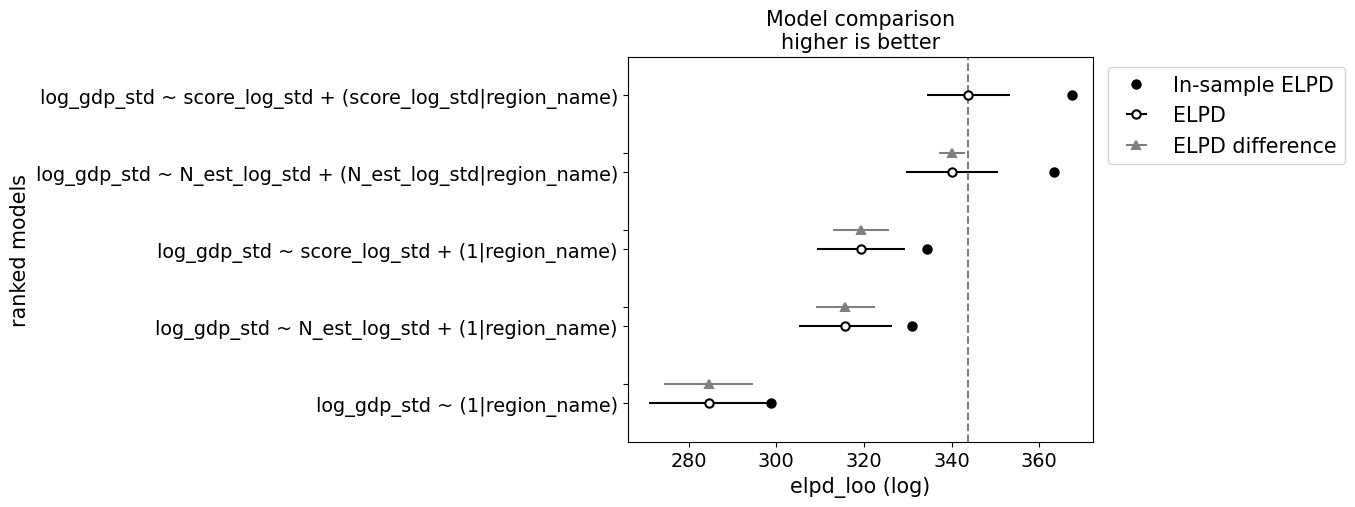

In [65]:
az.plot_compare(waic_compare.loc[waic_compare.index.str.contains("region_name")], insample_dev=True);

# Cultural score per capita

In the analsyses above, we correlated a global cultural production score (both corrected and uncorrected) with the GDP scores per capita. These scores ignore differences in population size. As a final step in the analysis, we repeat the analyses with varying intercepts and varying slopes, but swapping the unnormalized cultural production scores for the scores per capita. We begin with the uncorrected score:

In [66]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_score_cap_vi = bmb.Model(
    "log_gdp_std ~ score_cap_log_std + (1|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True, 
    priors=priors
)
m_score_cap_vi

       Formula: log_gdp_std ~ score_cap_log_std + (1|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 137
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            score_cap_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            sigma ~ Exponential(lam: 1.0)

The model graph looks as follows:

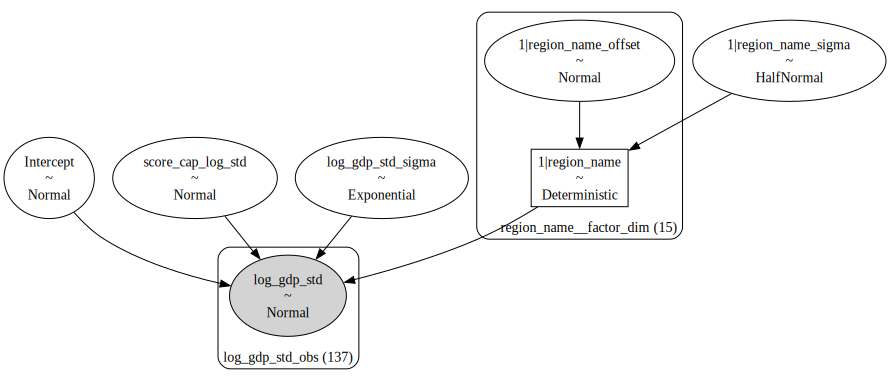

In [67]:
m_score_cap_vi.build()
m_score_cap_vi.graph()

In [68]:
m_score_cap_vi_fit = m_score_cap_vi.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,
    idata_kwargs={"log_likelihood": True}
)
models["log_gdp_std ~ score_cap_log_std + (1|region_name)"] = m_score_cap_vi_fit
az.summary(m_score_cap_vi_fit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, score_cap_log_std, 1|region_name_sigma, 1|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                        1.056  0.013   1.032    1.080        0.0   
score_cap_log_std               -0.064  0.008  -0.078   -0.049        0.0   
log_gdp_std_sigma                0.024  0.002   0.021    0.027        0.0   
1|region_name_sigma              0.037  0.008   0.023    0.053        0.0   
1|region_name[Arabic world]     -0.044  0.013  -0.069   -0.019        0.0   
1|region_name[Chinese world]     0.019  0.013  -0.006    0.044        0.0   
1|region_name[France]            0.007  0.012  -0.016    0.029        0.0   
1|region_name[German world]     -0.009  0.013  -0.034    0.016        0.0   
1|region_name[Greek World]       0.033  0.012   0.010    0.058        0.0   
1|region_name[Indian world]      0.017  0.015  -0.009    0.046        0.0   
1|region_name[Italy]             0.044  0.013   0.020    0.068        0.0   
1|region_name[Japan]            -0.019  0.013  -0.044    0.005        0.0   
1|region_name[Korea]            -0.045  0.018  -0.078   -0.011        0.0   
1|region_name[Low countries]     0.058  0.013   0.032    0.081        0.0   
1|region_name[Nordic countries] -0.013  0.012  -0.037    0.010        0.0   
1|region_name[Persian world]    -0.045  0.018  -0.079   -0.012        0.0   
1|region_name[Portugal]         -0.006  0.013  -0.032    0.018        0.0   
1|region_name[Spain]            -0.023  0.012  -0.045    0.000        0.0   
1|region_name[United Kingdom]    0.023  0.012   0.001    0.045        0.0   

                                 mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                            0.0    1787.0    2997.0    1.0  
score_cap_log_std                    0.0    3187.0    4836.0    1.0  
log_gdp_std_sigma                    0.0    5497.0    5149.0    1.0  
1|region_name_sigma                  0.0    1371.0    2470.0    1.0  
1|region_name[Arabic world]          0.0    2271.0    3930.0    1.0  
1|region_name[Chinese world]         0.0    1992.0    3346.0    1.0  
1|region_name[France]                0.0    1827.0    3008.0    1.0  
1|region_name[German world]          0.0    2175.0    3286.0    1.0  
1|region_name[Greek World]           0.0    1857.0    3093.0    1.0  
1|region_name[Indian world]          0.0    2304.0    3885.0    1.0  
1|region_name[Italy]                 0.0    2048.0    3456.0    1.0  
1|region_name[Japan]                 0.0    2131.0    3061.0    1.0  
1|region_name[Korea]                 0.0    3251.0    4314.0    1.0  
1|region_name[Low countries]         0.0    1934.0    3543.0    1.0  
1|region_name[Nordic countries]      0.0    1910.0    3014.0    1.0  
1|region_name[Persian world]         0.0    3416.0    4712.0    1.0  
1|region_name[Portugal]              0.0    2247.0    3441.0    1.0  
1|region_name[Spain]                 0.0    1944.0    3181.0    1.0  
1|region_name[United Kingdom]        0.0    1817.0    2946.0    1.0

Once again, the sampling appears to be successful, reflected by desirable $\hat{r}$ values and substantial effective sample sizes. The findings hint at a minimal positive global correlation between cultural production and GDP (0.023 CI [0.022, 0.025]). It seems that the model fit is decent. 

/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


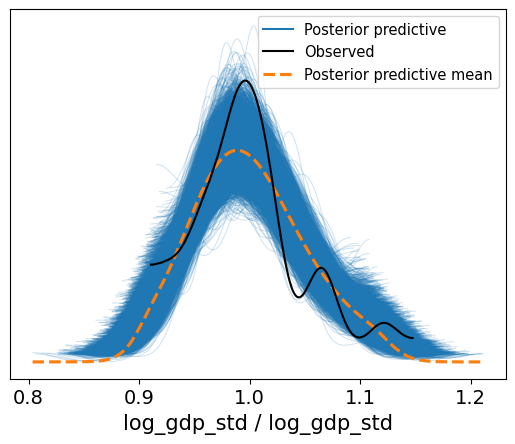

In [69]:
m_score_cap_vi.predict(m_score_cap_vi_fit, kind="pps")
az.plot_ppc(m_score_cap_vi_fit);

KeyboardInterrupt: 

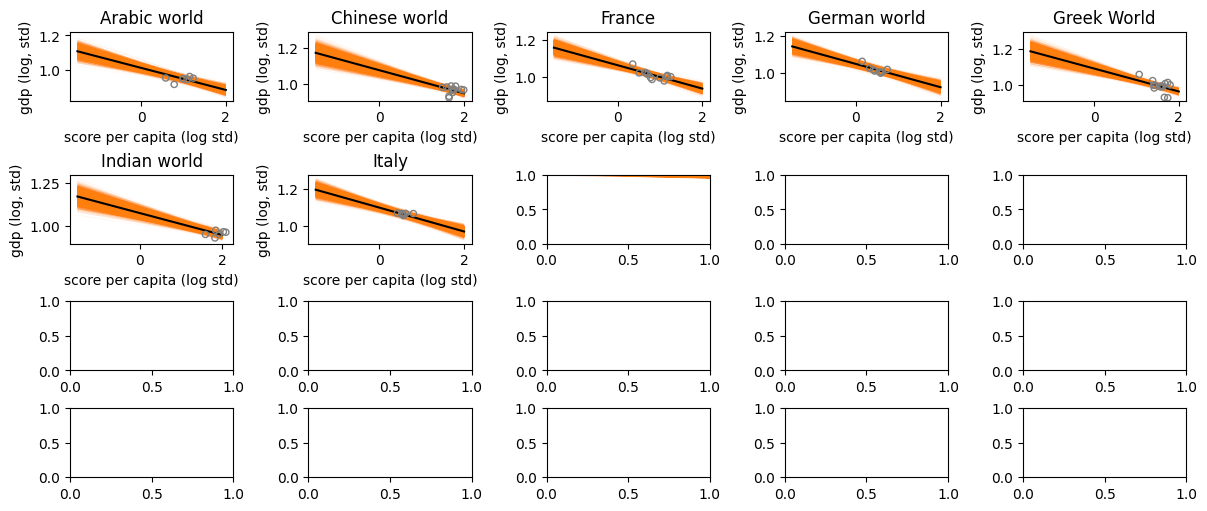

In [70]:
import xarray as xr

fig, axes = plt.subplots(ncols=5, nrows=4, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_score_cap_vi_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["score_cap_log_std"]
    score = np.array([-1.5, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = slope_common

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["score_cap_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="score per capita (log std)", title=region_name)

Here's another visualization of the posterior predictions: the intercepts differ, but the slope (_by design_) is the same, and thus always positive:

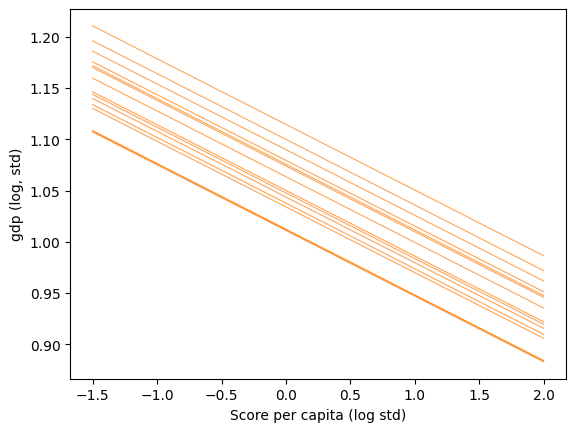

In [ ]:
posterior = az.extract(m_score_cap_vi_fit)
intercept_common = posterior["Intercept"]
slope_common = posterior["score_cap_log_std"]
score = np.array([-1.5, 2])

intercept_group_specific = posterior["1|region_name"]
a = intercept_common.mean() + intercept_group_specific.mean("sample")
b = slope_common.mean()
score_xi = xr.DataArray(score)
plt.plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.7, lw=0.8)
plt.ylabel("gdp (log, std)")
plt.xlabel("Score per capita (log std)");

We perform the same analysis, swapping the cultural production score for the bias-corrected score:

In [ ]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_est_cap_vi = bmb.Model(
    "log_gdp_std ~ N_est_cap_log_std + (1|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors)
m_est_cap_vi

       Formula: log_gdp_std ~ N_est_cap_log_std + (1|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 137
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            N_est_cap_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            sigma ~ Exponential(lam: 1.0)

In [ ]:
m_est_cap_vi_fit = m_est_cap_vi.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,
    idata_kwargs={"log_likelihood": True})

models["log_gdp_std ~ N_est_cap_log_std + (1|region_name)"] = m_est_cap_vi_fit
az.summary(m_est_cap_vi_fit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, N_est_cap_log_std, 1|region_name_sigma, 1|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                        1.011  0.011   0.990    1.032        0.0   
N_est_cap_log_std               -0.019  0.003  -0.024   -0.014        0.0   
log_gdp_std_sigma                0.024  0.002   0.022    0.027        0.0   
1|region_name_sigma              0.038  0.009   0.024    0.055        0.0   
1|region_name[Arabic world]     -0.040  0.014  -0.067   -0.016        0.0   
1|region_name[Chinese world]     0.019  0.014  -0.006    0.046        0.0   
1|region_name[France]            0.008  0.012  -0.016    0.032        0.0   
1|region_name[German world]     -0.012  0.014  -0.038    0.015        0.0   
1|region_name[Greek World]       0.024  0.013   0.001    0.048        0.0   
1|region_name[Indian world]      0.011  0.015  -0.017    0.039        0.0   
1|region_name[Italy]             0.042  0.014   0.017    0.068        0.0   
1|region_name[Japan]            -0.016  0.014  -0.041    0.010        0.0   
1|region_name[Korea]            -0.046  0.019  -0.080   -0.011        0.0   
1|region_name[Low countries]     0.067  0.013   0.041    0.091        0.0   
1|region_name[Nordic countries] -0.008  0.013  -0.033    0.016        0.0   
1|region_name[Persian world]    -0.046  0.019  -0.079   -0.009        0.0   
1|region_name[Portugal]         -0.010  0.014  -0.036    0.016        0.0   
1|region_name[Spain]            -0.023  0.013  -0.046    0.002        0.0   
1|region_name[United Kingdom]    0.026  0.012   0.003    0.049        0.0   

                                 mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                            0.0    1772.0    2763.0    1.0  
N_est_cap_log_std                    0.0    4122.0    4324.0    1.0  
log_gdp_std_sigma                    0.0    5492.0    5445.0    1.0  
1|region_name_sigma                  0.0    1629.0    3263.0    1.0  
1|region_name[Arabic world]          0.0    2567.0    3874.0    1.0  
1|region_name[Chinese world]         0.0    2467.0    3478.0    1.0  
1|region_name[France]                0.0    2212.0    3487.0    1.0  
1|region_name[German world]          0.0    2604.0    4243.0    1.0  
1|region_name[Greek World]           0.0    2205.0    3494.0    1.0  
1|region_name[Indian world]          0.0    2824.0    3987.0    1.0  
1|region_name[Italy]                 0.0    2489.0    4263.0    1.0  
1|region_name[Japan]                 0.0    2457.0    3840.0    1.0  
1|region_name[Korea]                 0.0    3749.0    5304.0    1.0  
1|region_name[Low countries]         0.0    2322.0    3933.0    1.0  
1|region_name[Nordic countries]      0.0    2217.0    3377.0    1.0  
1|region_name[Persian world]         0.0    3930.0    4367.0    1.0  
1|region_name[Portugal]              0.0    2526.0    3740.0    1.0  
1|region_name[Spain]                 0.0    2203.0    3637.0    1.0  
1|region_name[United Kingdom]        0.0    2151.0    3286.0    1.0

The fit appears to bear similarity to the prior model, and once more, the incorporated unidirectional relationship yields comparatively large residuals.

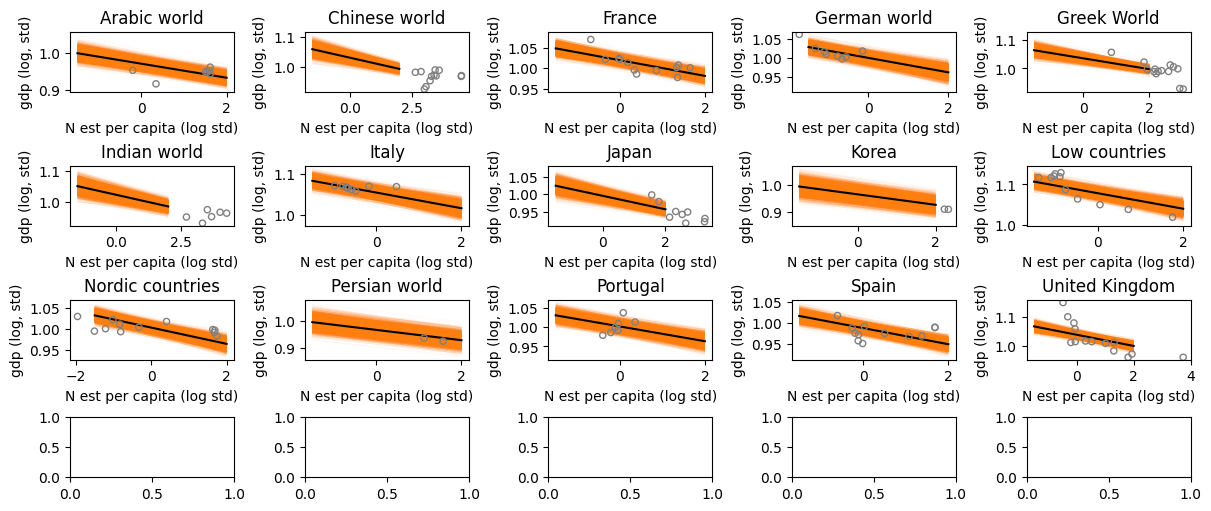

In [ ]:
import xarray as xr

fig, axes = plt.subplots(ncols=5, nrows=4, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_est_cap_vi_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["N_est_cap_log_std"]
    score = np.array([-1.5, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = slope_common

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["N_est_cap_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="N est per capita (log std)", title=region_name)

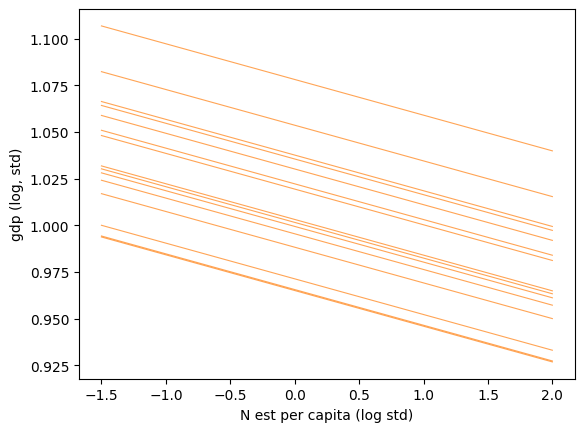

In [ ]:
posterior = az.extract(m_est_cap_vi_fit)
intercept_common = posterior["Intercept"]
slope_common = posterior["N_est_cap_log_std"]
score = np.array([-1.5, 2])

intercept_group_specific = posterior["1|region_name"]
a = intercept_common.mean() + intercept_group_specific.mean("sample")
b = slope_common.mean()
score_xi = xr.DataArray(score)
plt.plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.7, lw=0.8)
plt.ylabel("gdp (log, std)")
plt.xlabel("N est per capita (log std)");

### Varying Slopes for Cultural Production in Different Regions

In [ ]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "score_cap_log_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_score_cap_vs = bmb.Model(
    "log_gdp_std ~ score_cap_log_std + (score_cap_log_std|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)
m_score_cap_vs

       Formula: log_gdp_std ~ score_cap_log_std + (score_cap_log_std|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 137
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            score_cap_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
            score_cap_log_std|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            sigma ~ Exponential(lam: 1.0)

The model graph looks as follows:

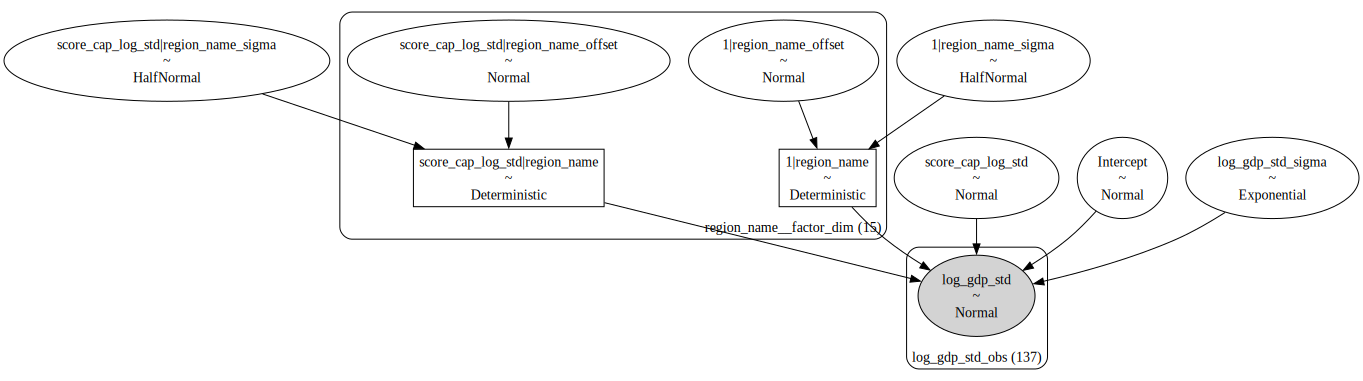

In [ ]:
m_score_cap_vs.build()
m_score_cap_vs.graph()

In [ ]:
m_score_cap_vs_fit = m_score_cap_vs.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,
    idata_kwargs={"log_likelihood": True})

models["log_gdp_std ~ score_cap_log_std + (score_cap_log_std|region_name)"] = m_score_cap_vs_fit
az.summary(m_score_cap_vs_fit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, score_cap_log_std, 1|region_name_sigma, 1|region_name_offset, score_cap_log_std|region_name_sigma, score_cap_log_std|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 22 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


mean     sd  hdi_3%  \
Intercept                                        1.052  0.018   1.016   
score_cap_log_std                               -0.061  0.014  -0.086   
log_gdp_std_sigma                                0.021  0.002   0.018   
1|region_name_sigma                              0.053  0.015   0.029   
score_cap_log_std|region_name_sigma              0.036  0.013   0.014   
1|region_name[Arabic world]                     -0.064  0.029  -0.119   
1|region_name[Chinese world]                    -0.013  0.038  -0.086   
1|region_name[France]                            0.008  0.022  -0.031   
1|region_name[German world]                     -0.001  0.021  -0.040   
1|region_name[Greek World]                       0.046  0.033  -0.010   
1|region_name[Indian world]                     -0.015  0.041  -0.099   
1|region_name[Italy]                             0.037  0.023  -0.006   
1|region_name[Japan]                             0.008  0.034  -0.055   
1|region_name[Korea]                            -0.028  0.040  -0.102   
1|region_name[Low countries]                     0.078  0.020   0.041   
1|region_name[Nordic countries]                 -0.030  0.019  -0.066   
1|region_name[Persian world]                    -0.032  0.035  -0.100   
1|region_name[Portugal]                         -0.019  0.028  -0.074   
1|region_name[Spain]                            -0.042  0.023  -0.085   
1|region_name[United Kingdom]                    0.063  0.023   0.023   
score_cap_log_std|region_name[Arabic world]      0.020  0.027  -0.026   
score_cap_log_std|region_name[Chinese world]     0.019  0.023  -0.022   
score_cap_log_std|region_name[France]            0.001  0.021  -0.038   
score_cap_log_std|region_name[German world]     -0.010  0.027  -0.061   
score_cap_log_std|region_name[Greek World]      -0.008  0.022  -0.049   
score_cap_log_std|region_name[Indian world]      0.017  0.023  -0.025   
score_cap_log_std|region_name[Italy]             0.020  0.031  -0.037   
score_cap_log_std|region_name[Japan]            -0.020  0.024  -0.065   
score_cap_log_std|region_name[Korea]            -0.017  0.028  -0.072   
score_cap_log_std|region_name[Low countries]    -0.037  0.023  -0.080   
score_cap_log_std|region_name[Nordic countries]  0.032  0.018  -0.003   
score_cap_log_std|region_name[Persian world]    -0.017  0.029  -0.076   
score_cap_log_std|region_name[Portugal]          0.020  0.034  -0.038   
score_cap_log_std|region_name[Spain]             0.025  0.023  -0.016   
score_cap_log_std|region_name[United Kingdom]   -0.043  0.021  -0.083   

                                                 hdi_97%  mcse_mean  mcse_sd  \
Intercept                                          1.083      0.000      0.0   
score_cap_log_std                                 -0.034      0.000      0.0   
log_gdp_std_sigma                                  0.024      0.000      0.0   
1|region_name_sigma                                0.080      0.000      0.0   
score_cap_log_std|region_name_sigma                0.061      0.000      0.0   
1|region_name[Arabic world]                       -0.012      0.000      0.0   
1|region_name[Chinese world]                       0.058      0.001      0.0   
1|region_name[France]                              0.053      0.000      0.0   
1|region_name[German world]                        0.040      0.000      0.0   
1|region_name[Greek World]                         0.113      0.001      0.0   
1|region_name[Indian world]                        0.058      0.001      0.0   
1|region_name[Italy]                               0.083      0.000      0.0   
1|region_name[Japan]                               0.070      0.000      0.0   
1|region_name[Korea]                               0.048      0.001      0.0   
1|region_name[Low countries]                       0.118      0.000      0.0   
1|region_name[Nordic countries]                    0.006      0.000      0.0   
1|region_name[Persian world]                       0.031     

Echoing our previous approach, we conduct a posterior predictive check and find that the model aligns with the data far more effectively. The difference with the simpler models is really remarkable:

/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


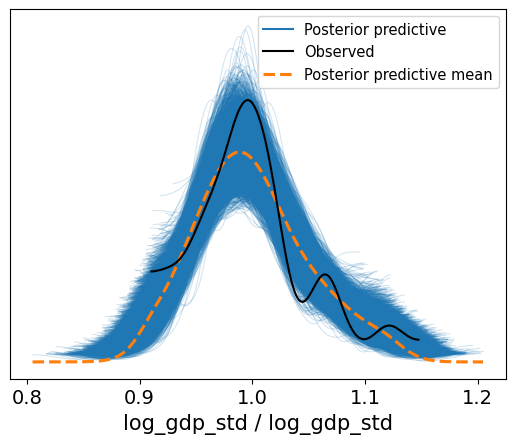

In [ ]:
m_score_cap_vs.predict(m_score_cap_vs_fit, kind="pps")
az.plot_ppc(m_score_cap_vs_fit);

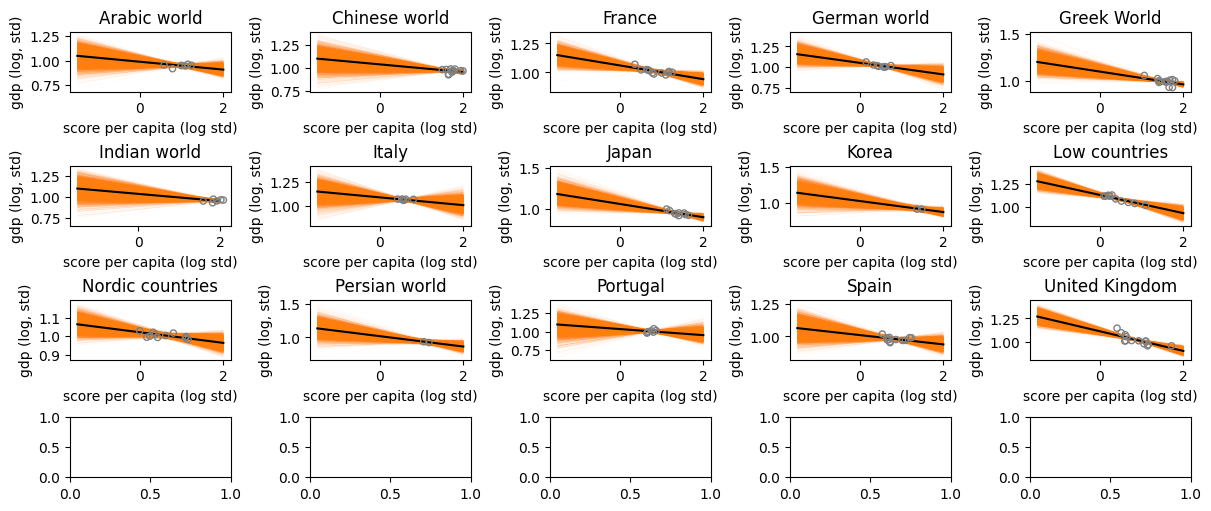

In [ ]:
fig, axes = plt.subplots(ncols=5, nrows=4, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_score_cap_vs_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["score_cap_log_std"]
    score = np.array([-1.5, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    slope_specific_0 = posterior["score_cap_log_std|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = (slope_common + slope_specific_0)

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["score_cap_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="score per capita (log std)", title=region_name)

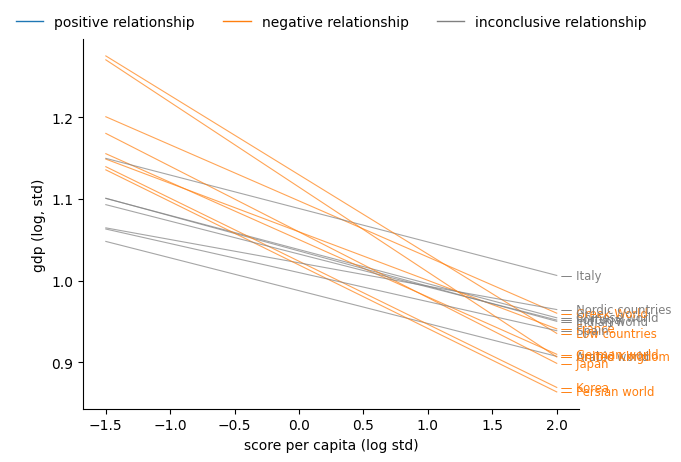

In [ ]:
from matplotlib.lines import Line2D

intercept_group_specific = posterior["1|region_name"]
slope_group_specific = posterior["score_cap_log_std|region_name"]

a = intercept_common + intercept_group_specific
b = slope_common + slope_group_specific

score_xi = xr.DataArray(score)

fig, ax = plt.subplots()
for region in df["region_name"].unique():

    a_region = a.sel(region_name__factor_dim=region)
    b_region = b.sel(region_name__factor_dim=region)
    
    Y = (a_region + b_region * score_xi)
    Y_mean = Y.mean(axis=0)

    color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
             "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
             "grey")
    ax.plot(score_xi, Y_mean, color=color, alpha=0.7, lw=0.8, label=region)
    ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + region,
        size="small",
        color=color,
        ha="left",
        va="center",
    )
    
ax.spines[['right', 'top']].set_visible(False)
custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]
ax.legend(custom_lines, ['positive relationship', 'negative relationship', 'inconclusive relationship'], 
           loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.1), frameon=False)
ax.set(ylabel="gdp (log, std)", xlabel="score per capita (log std)");

Below, I repeat the analysis, again swapping cultural production for the bias-corrected score.

In [ ]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "N_est_cap_log_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_est_cap_vs = bmb.Model(
    "log_gdp_std ~  N_est_cap_log_std + (N_est_cap_log_std|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)
m_est_cap_vs

       Formula: log_gdp_std ~  N_est_cap_log_std + (N_est_cap_log_std|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 137
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            N_est_cap_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
            N_est_cap_log_std|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            sigma ~ Exponential(lam: 1.0)

In [ ]:
m_est_cap_vs_fit = m_est_cap_vs.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.95,
    idata_kwargs={"log_likelihood": True})

models["log_gdp_std ~ N_est_cap_log_std + (N_est_cap_log_std|region_name)"] = m_est_cap_vs_fit
az.summary(m_est_cap_vs_fit)

# NB: hitting max_treedepth is not much of a concern, at least not for model validity
# For more information about this and other warnings, see https://mc-stan.org/misc/warnings.html
# TODO, see if we can improve efficiency

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, N_est_cap_log_std, 1|region_name_sigma, 1|region_name_offset, N_est_cap_log_std|region_name_sigma, N_est_cap_log_std|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 21 seconds.


mean     sd  hdi_3%  \
Intercept                                        1.010  0.013   0.985   
N_est_cap_log_std                               -0.018  0.006  -0.029   
log_gdp_std_sigma                                0.021  0.001   0.018   
1|region_name_sigma                              0.044  0.011   0.025   
N_est_cap_log_std|region_name_sigma              0.017  0.006   0.007   
1|region_name[Arabic world]                     -0.055  0.018  -0.089   
1|region_name[Chinese world]                    -0.022  0.028  -0.076   
1|region_name[France]                            0.011  0.015  -0.017   
1|region_name[German world]                     -0.014  0.018  -0.046   
1|region_name[Greek World]                       0.052  0.023   0.010   
1|region_name[Indian world]                     -0.019  0.033  -0.082   
1|region_name[Italy]                             0.049  0.016   0.020   
1|region_name[Japan]                             0.008  0.025  -0.038   
1|region_name[Korea]                            -0.030  0.032  -0.088   
1|region_name[Low countries]                     0.062  0.015   0.034   
1|region_name[Nordic countries]                 -0.006  0.014  -0.033   
1|region_name[Persian world]                    -0.039  0.025  -0.087   
1|region_name[Portugal]                         -0.008  0.015  -0.036   
1|region_name[Spain]                            -0.027  0.014  -0.054   
1|region_name[United Kingdom]                    0.039  0.015   0.012   
N_est_cap_log_std|region_name[Arabic world]      0.014  0.010  -0.005   
N_est_cap_log_std|region_name[Chinese world]     0.012  0.009  -0.005   
N_est_cap_log_std|region_name[France]           -0.003  0.009  -0.019   
N_est_cap_log_std|region_name[German world]     -0.004  0.012  -0.026   
N_est_cap_log_std|region_name[Greek World]      -0.012  0.010  -0.030   
N_est_cap_log_std|region_name[Indian world]      0.009  0.010  -0.009   
N_est_cap_log_std|region_name[Italy]             0.007  0.012  -0.015   
N_est_cap_log_std|region_name[Japan]            -0.010  0.010  -0.028   
N_est_cap_log_std|region_name[Korea]            -0.010  0.014  -0.037   
N_est_cap_log_std|region_name[Low countries]    -0.017  0.008  -0.034   
N_est_cap_log_std|region_name[Nordic countries]  0.012  0.007  -0.001   
N_est_cap_log_std|region_name[Persian world]    -0.008  0.016  -0.039   
N_est_cap_log_std|region_name[Portugal]          0.014  0.017  -0.017   
N_est_cap_log_std|region_name[Spain]             0.013  0.008  -0.003   
N_est_cap_log_std|region_name[United Kingdom]   -0.015  0.007  -0.027   

                                                 hdi_97%  mcse_mean  mcse_sd  \
Intercept                                          1.035        0.0      0.0   
N_est_cap_log_std                                 -0.008        0.0      0.0   
log_gdp_std_sigma                                  0.024        0.0      0.0   
1|region_name_sigma                                0.065        0.0      0.0   
N_est_cap_log_std|region_name_sigma                0.027        0.0      0.0   
1|region_name[Arabic world]                       -0.022        0.0      0.0   
1|region_name[Chinese world]                       0.029        0.0      0.0   
1|region_name[France]                              0.038        0.0      0.0   
1|region_name[German world]                        0.020        0.0      0.0   
1|region_name[Greek World]                         0.096        0.0      0.0   
1|region_name[Indian world]                        0.038        0.0      0.0   
1|region_name[Italy]                               0.080        0.0      0.0   
1|region_name[Japan]                               0.055        0.0      0.0   
1|region_name[Korea]                               0.031        0.0      0.0   
1|region_name[Low countries]                       0.090        0.0      0.0   
1|region_name[Nordic countries]                    0.021        0.0      0.0   
1|region_name[Persian world]                       0.009     

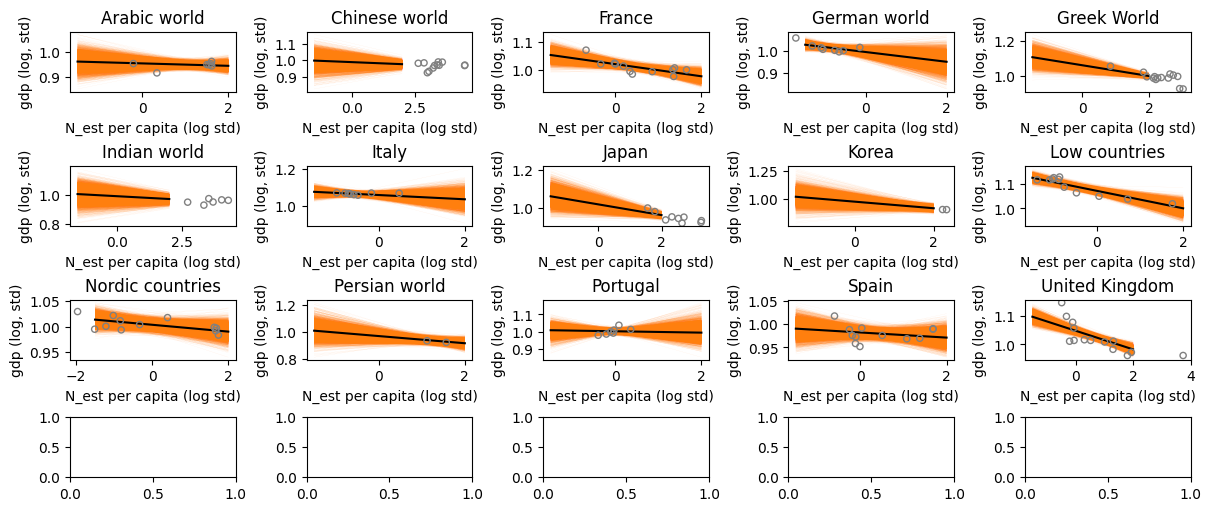

In [ ]:
fig, axes = plt.subplots(ncols=5, nrows=4, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_est_cap_vs_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["N_est_cap_log_std"]
    score = np.array([-1.5, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    slope_specific_0 = posterior["N_est_cap_log_std|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = (slope_common + slope_specific_0)

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["N_est_cap_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="N_est per capita (log std)", title=region_name)

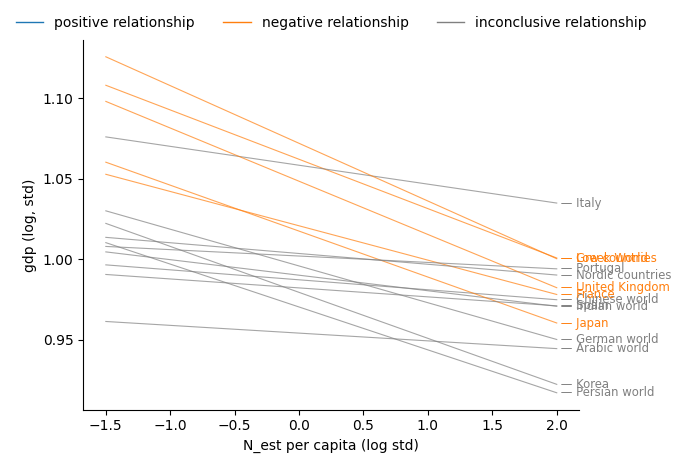

In [ ]:
from matplotlib.lines import Line2D

intercept_group_specific = posterior["1|region_name"]
slope_group_specific = posterior["N_est_cap_log_std|region_name"]

a = intercept_common + intercept_group_specific
b = slope_common + slope_group_specific

score_xi = xr.DataArray(score)

fig, ax = plt.subplots()
for region in df["region_name"].unique():

    a_region = a.sel(region_name__factor_dim=region)
    b_region = b.sel(region_name__factor_dim=region)
    
    Y = (a_region + b_region * score_xi)
    Y_mean = Y.mean(axis=0)

    color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
             "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
             "grey")
    ax.plot(score_xi, Y_mean, color=color, alpha=0.7, lw=0.8, label=region)
    ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + region,
        size="small",
        color=color,
        ha="left",
        va="center",
    )
    
ax.spines[['right', 'top']].set_visible(False)
custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]
ax.legend(custom_lines, ['positive relationship', 'negative relationship', 'inconclusive relationship'], 
           loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.1), frameon=False)
ax.set(ylabel="gdp (log, std)", xlabel="N_est per capita (log std)");

fig.savefig('results_BRM/gpd_index_relationship.png')

#### Model comparison

Finally, we execute a comparison across all models evaluated thus far. The comparison decisively underscores that incorporating varying slopes dramatically enhances the model fit, considerably outpacing the performance of the other models. Furthermore, we note that the bias-correction does not improve the model fit considerably. Finally, representing the cultural scores per capita does not improve the model fit either. 

In [ ]:
waic_compare = az.compare(models, ic='LOO')

/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn

In [ ]:
waic_compare['elpd_loo'] = round(waic_compare['elpd_loo'], 0)

In [ ]:
waic_compare

rank  elpd_loo      p_loo  \
log_gdp_std ~ score_log_std + (score_log_std|re...     0     343.0  23.841112   
log_gdp_std ~ N_est_log_std + (N_est_log_std|re...     1     339.0  23.565752   
log_gdp_std ~ score_cap_log_std + (score_cap_lo...     2     322.0  21.029304   
log_gdp_std ~ N_est_cap_log_std + (N_est_cap_lo...     3     322.0  23.804023   
log_gdp_std ~ score_log_std + (1|region_name)          4     319.0  15.077084   
log_gdp_std ~ N_est_log_std + (1|region_name)          5     314.0  15.187265   
log_gdp_std ~ score_cap_log_std + (1|region_name)      6     310.0  14.710493   
log_gdp_std ~ N_est_cap_log_std + (1|region_name)      7     306.0  14.848626   
log_gdp_std ~ (1|region_name)                          8     285.0  13.716499   
gdp ~ N_est_log_std                                    9     243.0   2.938456   
gdp ~ score_log_std                                   10     242.0   2.834498   

                                                     elpd_diff   weight  \
log_gdp_std ~ score_log_std + (score_log_std|re...    0.000000  0.97169   
log_gdp_std ~ N_est_log_std + (N_est_log_std|re...    4.781222  0.00000   
log_gdp_std ~ score_cap_log_std + (score_cap_lo...   21.580515  0.00000   
log_gdp_std ~ N_est_cap_log_std + (N_est_cap_lo...   21.836304  0.00000   
log_gdp_std ~ score_log_std + (1|region_name)        24.150327  0.02831   
log_gdp_std ~ N_est_log_std + (1|region_name)        28.890011  0.00000   
log_gdp_std ~ score_cap_log_std + (1|region_name)    33.576898  0.00000   
log_gdp_std ~ N_est_cap_log_std + (1|region_name)    36.993894  0.00000   
log_gdp_std ~ (1|region_name)                        58.415816  0.00000   
gdp ~ N_est_log_std                                 100.795525  0.00000   
gdp ~ score_log_std                                 101.357490  0.00000   

                                                           se        dse  \
log_gdp_std ~ score_log_std + (score_log_std|re...   9.503369   0.000000   
log_gdp_std ~ N_est_log_std + (N_est_log_std|re...  10.703878   2.831914   
log_gdp_std ~ score_cap_log_std + (score_cap_lo...  10.856099   4.852141   
log_gdp_std ~ N_est_cap_log_std + (N_est_cap_lo...  12.196768   5.355609   
log_gdp_std ~ score_log_std + (1|region_name)       10.086401   6.376085   
log_gdp_std ~ N_est_log_std + (1|region_name)       10.630116   6.727661   
log_gdp_std ~ score_cap_log_std + (1|region_name)   11.025147   7.019040   
log_gdp_std ~ N_est_cap_log_std + (1|region_name)   11.657639   7.546957   
log_gdp_std ~ (1|region_name)                       13.545759   9.984374   
gdp ~ N_est_log_std                                  8.474676  10.960434   
gdp ~ score_log_std                                  7.607858  10.524347   

                                                    warning scale  
log_gdp_std ~ score_log_std + (score_log_std|re...     True   log  
log_gdp_std ~ N_est_log_std + (N_est_log_std|re...     True   log  
log_gdp_std ~ score_cap_log_std + (score_cap_lo...     True   log  
log_gdp_std ~ N_est_cap_log_std + (N_est_cap_lo...     True   log  
log_gdp_std ~ score_log_std + (1|region_name)         False   log  
log_gdp_std ~ N_est_log_std + (1|region_name)         False   log  
log_gdp_std ~ score_cap_log_std + (1|region_name)     False   log  
log_gdp_std ~ N_est_cap_log_std + (1|region_name)      True   log  
log_gdp_std ~ (1|region_name)                         False   log  
gdp ~ N_est_log_std                                   False   log  
gdp ~ score_log_std                                   False   log

/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/arviz/plots/compareplot.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df.sort_values(by="rank", inplace=True)
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


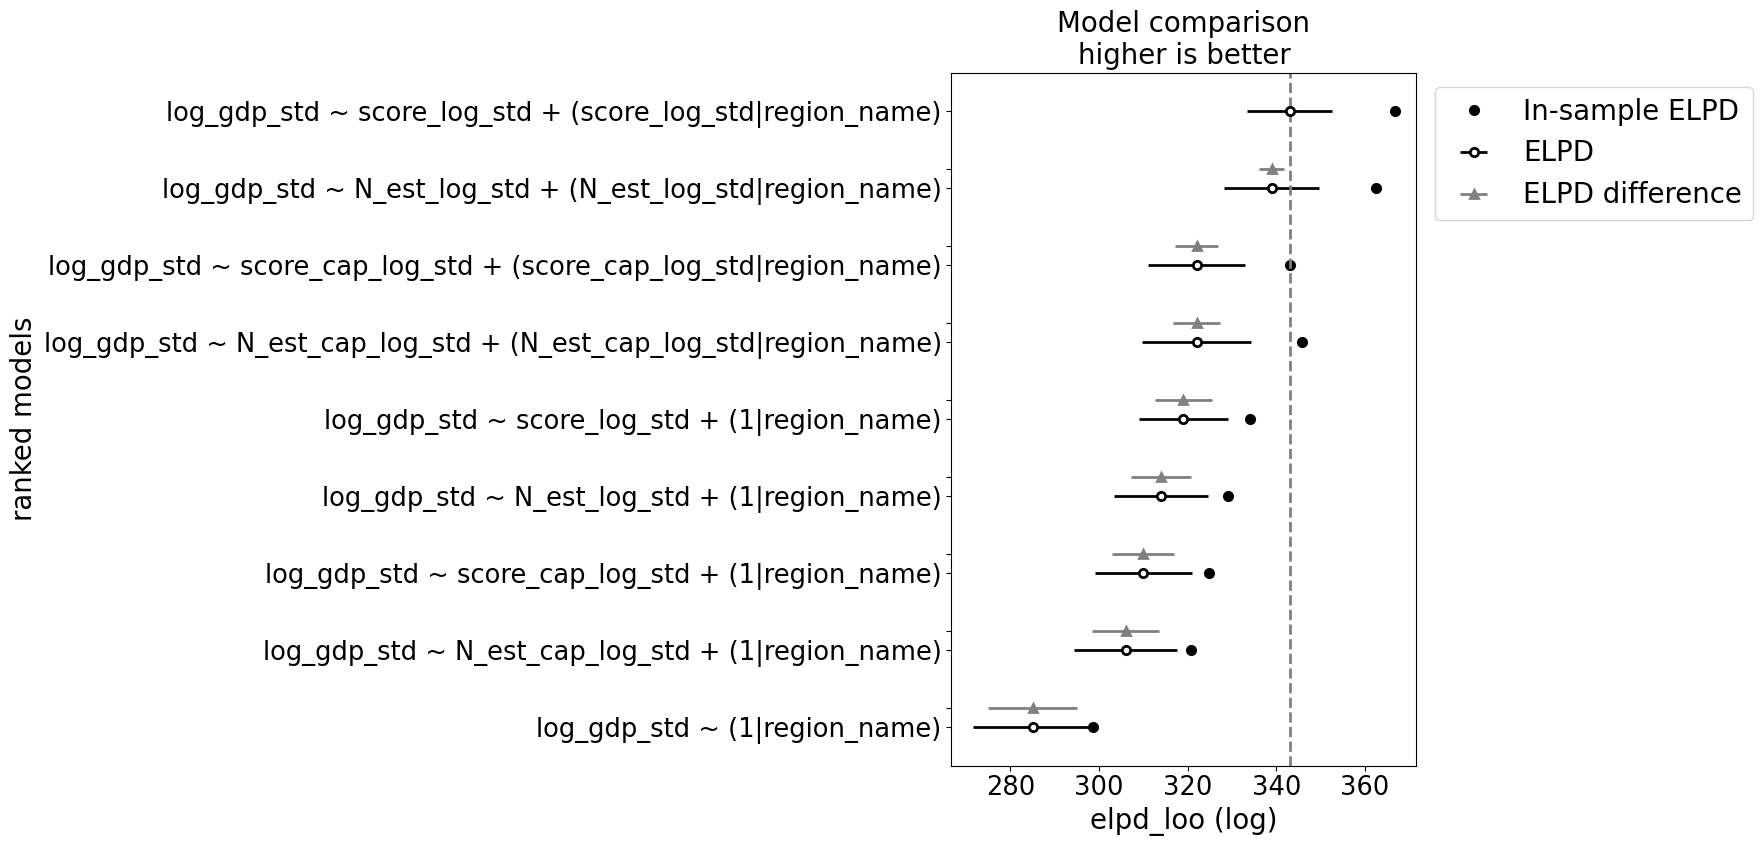

In [ ]:
# Your existing code to create the plot
axes = az.plot_compare(waic_compare.loc[waic_compare.index.str.contains("region_name")], insample_dev=True)

# Get the figure from the axes
fig = axes.figure

In [ ]:
# Save the figure to a file
fig.savefig('results_BRM/model_comparison', dpi=300) 